# HMDB Metabolite Search Evaluation Results

This notebook visualizes evaluation results from the 4D evaluation pipeline for metabolite search:

**Evaluation Dimensions:**
- **4 models**: minilm, bge-m3, sapbert, biolord
- **9 index types**: flat, hnsw, hnsw_sq8, hnsw_sq4, hnsw_pq, ivf_flat, ivf_sq8, ivf_sq4, ivf_pq
- **3 strategies**: single-primary, single-pooled, multi-vector

**Metrics Tracked:**
- Recall@k (k=1, 5, 10, 20, 50, 100)
- MRR (Mean Reciprocal Rank)
- Latency (P50, P95, P99)
- Index Size

**Per-Category Metrics (7 query types):**
- exact_match, synonym_match, fuzzy_match
- greek_letter, numeric_prefix, special_prefix
- **arivale** (real-world queries)

**Data Source:** `results/full_synonyms_108_weight1/evaluation_results.json`

## 1. Setup and Data Loading

In [1]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Paths - Updated for weight=1.0 evaluation results
RESULTS_PATH = Path("../results/full_synonyms_108_weight1/evaluation_results.json")
OUTPUT_DIR = Path("../results/figures")
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

print(f"Results path: {RESULTS_PATH.resolve()}")
print(f"Output directory: {OUTPUT_DIR.resolve()}")

Results path: /home/trentleslie/Insync/projects/biovector-eval/results/full_synonyms_108_weight1/evaluation_results.json
Output directory: /home/trentleslie/Insync/projects/biovector-eval/results/figures


In [2]:
def load_evaluation_results(path: Path) -> tuple[dict, pd.DataFrame]:
    """Load results and convert to DataFrame."""
    with open(path) as f:
        data = json.load(f)
    
    # Flatten results into DataFrame
    records = []
    for result in data["results"]:
        record = {**result["config"], **result["metrics"]}
        records.append(record)
    
    df = pd.DataFrame(records)
    return data, df

data, df = load_evaluation_results(RESULTS_PATH)

# Filter out gte-qwen2 (not evaluated in this run)
df = df[df['model'] != 'gte-qwen2']

print(f"Loaded {len(df)} configurations")
print(f"Models: {df['model'].unique().tolist()}")
print(f"Strategies: {df['strategy'].unique().tolist()}")
print(f"Index types: {df['index_type'].unique().tolist()}")

Loaded 108 configurations
Models: ['bge-m3', 'sapbert', 'biolord', 'minilm']
Strategies: ['single-primary', 'single-pooled', 'multi-vector']
Index types: ['flat', 'hnsw', 'hnsw_sq8', 'hnsw_sq4', 'hnsw_pq', 'ivf_flat', 'ivf_sq8', 'ivf_sq4', 'ivf_pq']


In [3]:
# Data Preprocessing and Feature Engineering

# Add derived columns
df['config_label'] = df['model'] + ' / ' + df['strategy'] + ' / ' + df['index_type']

# Categorize index types by compression level (updated for 9 index types)
index_compression = {
    'flat': 'none',
    'hnsw': 'none',
    'hnsw_sq8': 'hnsw+scalar',
    'hnsw_sq4': 'hnsw+scalar',
    'hnsw_pq': 'hnsw+product',
    'ivf_flat': 'ivf',
    'ivf_sq8': 'ivf+scalar',
    'ivf_sq4': 'ivf+scalar',
    'ivf_pq': 'ivf+product',
}
df['compression_type'] = df['index_type'].map(index_compression)

# Check if extended k values are available
has_extended_k = 'recall@100' in df.columns

# Compute LLM benefit score using highest available k
max_recall_col = 'recall@100' if has_extended_k else 'recall@10'
df['llm_benefit_score'] = np.where(
    df[max_recall_col] > 0,
    (df[max_recall_col] - df['recall@1']) / df[max_recall_col],
    0
)

# Compute gains between k values (if extended k available)
if has_extended_k:
    df['gain_1_5'] = df['recall@5'] - df['recall@1']
    df['gain_5_10'] = df['recall@10'] - df['recall@5']
    df['gain_10_20'] = df['recall@20'] - df['recall@10']
    df['gain_20_50'] = df['recall@50'] - df['recall@20']
    df['gain_50_100'] = df['recall@100'] - df['recall@50']
    df['llm_headroom'] = df['recall@100'] - df['recall@1']
    print(f"Extended k values detected: recall@20, @50, @100")

# Check for per-category metrics (including arivale)
has_category_metrics = 'recall@1_exact_match' in df.columns
if has_category_metrics:
    # Check for arivale category
    has_arivale = 'recall@1_arivale' in df.columns
    n_cats = 7 if has_arivale else 6
    print(f"Per-category metrics detected: {n_cats} categories available")

print(f"Max recall column for LLM score: {max_recall_col}")
print(f"\nDataFrame shape: {df.shape}")
print(f"Models: {df['model'].unique().tolist()}")
print(f"Strategies: {df['strategy'].unique().tolist()}")
print(f"Index types: {df['index_type'].unique().tolist()}")
df.head()

Extended k values detected: recall@20, @50, @100
Per-category metrics detected: 7 categories available
Max recall column for LLM score: recall@100

DataFrame shape: (108, 67)
Models: ['bge-m3', 'sapbert', 'biolord', 'minilm']
Strategies: ['single-primary', 'single-pooled', 'multi-vector']
Index types: ['flat', 'hnsw', 'hnsw_sq8', 'hnsw_sq4', 'hnsw_pq', 'ivf_flat', 'ivf_sq8', 'ivf_sq4', 'ivf_pq']


,model,index_type,strategy,recall@1,recall@5,recall@10,recall@20,recall@50,recall@100,mrr,...,recall@100_arivale,config_label,compression_type,llm_benefit_score,gain_1_5,gain_5_10,gain_10_20,gain_20_50,gain_50_100,llm_headroom
0,bge-m3,flat,single-primary,0.5870,0.6795,0.7150,0.7380,0.7617,0.7853,0.6289,...,0.7496,bge-m3 / single-primary / flat,none,0.252515,0.0925,0.0355,0.0230,0.0237,0.0236,0.1983
1,bge-m3,flat,single-pooled,0.4441,0.6025,0.6403,0.6765,0.7246,0.7587,0.5147,...,0.8740,bge-m3 / single-pooled / flat,none,0.414657,0.1584,0.0378,0.0362,0.0481,0.0341,0.3146
2,bge-m3,flat,multi-vector,0.7557,0.8690,0.8942,0.9208,0.9482,0.9578,0.8091,...,0.9401,bge-m3 / multi-vector / flat,none,0.211004,0.1133,0.0252,0.0266,0.0274,0.0096,0.2021
3,bge-m3,hnsw,single-primary,0.5803,0.6691,0.7017,0.7217,0.7417,0.7617,0.6203,...,0.7035,bge-m3 / single-primary / hnsw,none,0.238152,0.0888,0.0326,0.0200,0.0200,0.0200,0.1814
4,bge-m3,hnsw,single-pooled,0.4293,0.5811,0.6151,0.6477,0.6906,0.7254,0.4964,...,0.8295,bge-m3 / single-pooled / hnsw,none,0.408189,0.1518,0.0340,0.0326,0.0429,0.0348,0.2961


## 2. Summary Statistics and Key Findings

In [4]:
def display_summary(data: dict) -> pd.DataFrame:
    """Display key findings from evaluation."""
    summary = data["summary"]
    
    findings = pd.DataFrame([
        {
            "Metric": "Best Recall@1",
            "Value": f"{summary['best_recall']['recall@1']:.3f}",
            "Model": summary['best_recall']['config']['model'],
            "Strategy": summary['best_recall']['config']['strategy'],
            "Index": summary['best_recall']['config']['index_type'],
        },
        {
            "Metric": "Best MRR", 
            "Value": f"{summary['best_mrr']['mrr']:.3f}",
            "Model": summary['best_mrr']['config']['model'],
            "Strategy": summary['best_mrr']['config']['strategy'],
            "Index": summary['best_mrr']['config']['index_type'],
        },
        {
            "Metric": "Best Latency (P95)",
            "Value": f"{summary['best_latency']['p95_ms']:.2f} ms",
            "Model": summary['best_latency']['config']['model'],
            "Strategy": summary['best_latency']['config']['strategy'],
            "Index": summary['best_latency']['config']['index_type'],
        },
        {
            "Metric": "Smallest Index",
            "Value": f"{summary['smallest_index']['index_size_mb']:.1f} MB",
            "Model": summary['smallest_index']['config']['model'],
            "Strategy": summary['smallest_index']['config']['strategy'],
            "Index": summary['smallest_index']['config']['index_type'],
        },
    ])
    
    return findings

summary_df = display_summary(data)
summary_df.style.set_properties(**{'text-align': 'left'})

,Metric,Value,Model,Strategy,Index
0,Best Recall@1,0.781,minilm,multi-vector,flat
1,Best MRR,0.835,minilm,multi-vector,flat
2,Best Latency (P95),9.70 ms,minilm,single-pooled,ivf_pq
3,Smallest Index,9.4 MB,minilm,single-primary,ivf_pq


In [5]:
# Descriptive Statistics by Dimension

# Statistics by model
model_stats = df.groupby('model').agg({
    'recall@1': ['mean', 'std', 'max'],
    'mrr': ['mean', 'max'],
    'p95_ms': ['mean', 'min'],
    'index_size_mb': ['mean', 'min', 'max']
}).round(3)

print("Statistics by Model:")
display(model_stats)

Statistics by Model:


recall@1                  mrr          p95_ms          index_size_mb  \
            mean    std    max   mean    max     mean      min          mean   
model                                                                          
bge-m3     0.535  0.146  0.757  0.589  0.810  228.214  170.593      1278.385   
biolord    0.535  0.166  0.765  0.597  0.820   96.876   50.726       981.641   
minilm     0.514  0.160  0.781  0.570  0.835   23.183    9.699       536.544   
sapbert    0.572  0.132  0.759  0.637  0.821   87.757   44.374       981.641   

                       
          min     max  
model                  
bge-m3   11.1  7286.6  
biolord  10.4  5578.4  
minilm    9.4  3016.2  
sapbert  10.4  5578.4

In [6]:
# Statistics by strategy
strategy_stats = df.groupby('strategy').agg({
    'recall@1': ['mean', 'std', 'max'],
    'mrr': ['mean', 'max'],
    'p95_ms': ['mean', 'min'],
    'index_size_mb': ['mean', 'min', 'max']
}).round(3)

print("Statistics by Strategy:")
display(strategy_stats)

Statistics by Strategy:


recall@1                  mrr          p95_ms          \
                   mean    std    max   mean    max     mean     min   
strategy                                                               
multi-vector      0.689  0.089  0.781  0.748  0.835  136.341  11.313   
single-pooled     0.375  0.075  0.489  0.447  0.568   96.312   9.699   
single-primary    0.553  0.068  0.623  0.601  0.672   94.369   9.980   

               index_size_mb                
                        mean   min     max  
strategy                                    
multi-vector        2267.586  69.0  7286.6  
single-pooled        283.036   9.4   907.8  
single-primary       283.036   9.4   907.8

## 3. Comparison Bar Charts

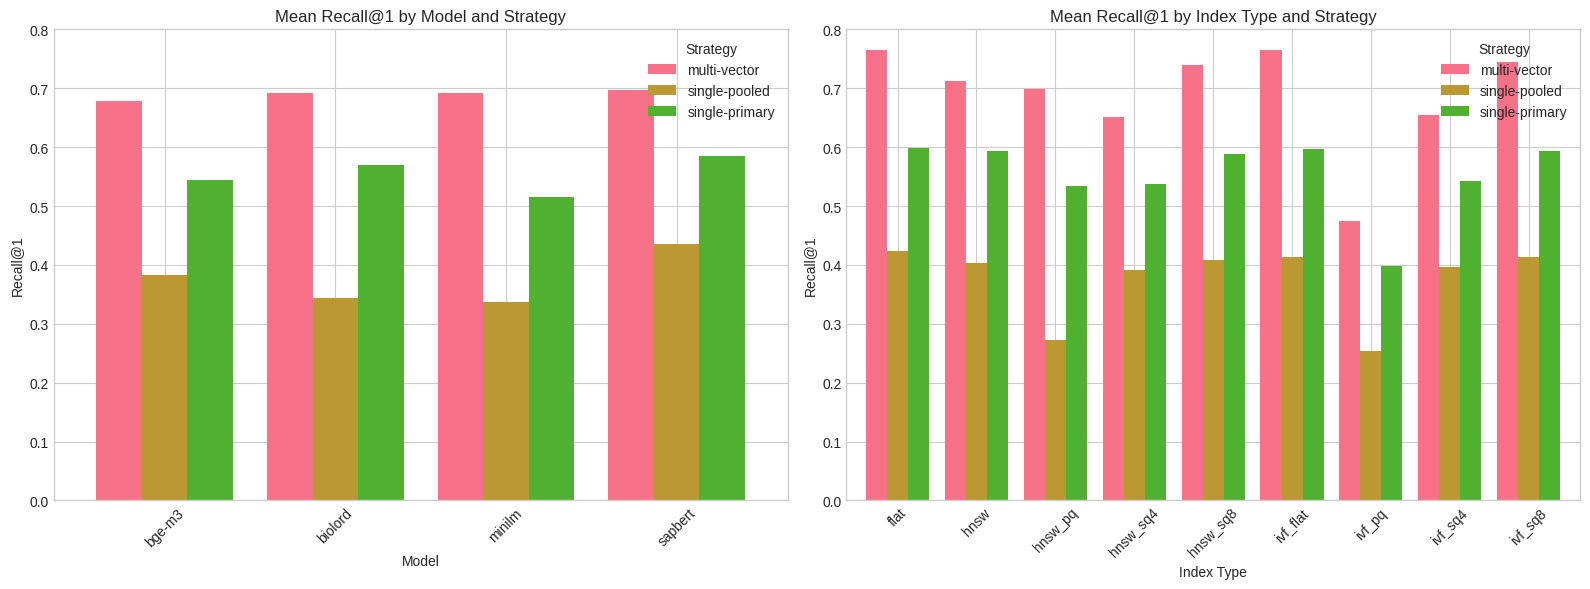

In [7]:
# Recall@1 by Model (Grouped by Strategy) - Seaborn

# Use all data (no anomalies to filter in current results)
df_valid = df.copy()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Recall by Model grouped by Strategy
ax1 = axes[0]
pivot_model = df_valid.pivot_table(
    index='model', 
    columns='strategy', 
    values='recall@1', 
    aggfunc='mean'
)
pivot_model.plot(kind='bar', ax=ax1, width=0.8)
ax1.set_title('Mean Recall@1 by Model and Strategy')
ax1.set_xlabel('Model')
ax1.set_ylabel('Recall@1')
ax1.set_ylim(0, 0.8)
ax1.legend(title='Strategy', loc='upper right')
ax1.tick_params(axis='x', rotation=45)

# Right: Recall by Index Type grouped by Strategy  
ax2 = axes[1]
pivot_index = df_valid.pivot_table(
    index='index_type', 
    columns='strategy', 
    values='recall@1', 
    aggfunc='mean'
)
pivot_index.plot(kind='bar', ax=ax2, width=0.8)
ax2.set_title('Mean Recall@1 by Index Type and Strategy')
ax2.set_xlabel('Index Type')
ax2.set_ylabel('Recall@1')
ax2.set_ylim(0, 0.8)
ax2.legend(title='Strategy', loc='upper right')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'recall_comparison_bars.png', dpi=150, bbox_inches='tight')
plt.show()

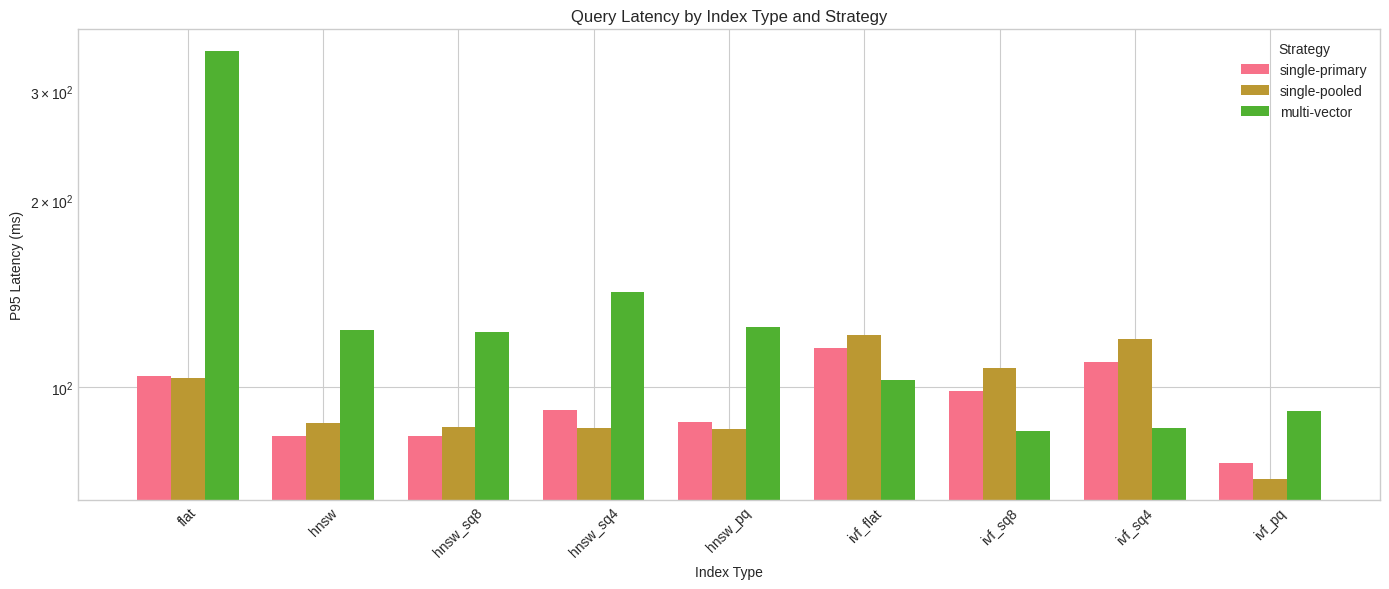

In [8]:
# Latency Comparison Bar Chart

fig, ax = plt.subplots(figsize=(14, 6))

# Create grouped bar chart
index_types = df['index_type'].unique()
x = np.arange(len(index_types))
width = 0.25

strategies = df['strategy'].unique()
for i, strategy in enumerate(strategies):
    subset = df_valid[df_valid['strategy'] == strategy].groupby('index_type')['p95_ms'].mean()
    offset = (i - 1) * width
    ax.bar(x + offset, subset.reindex(index_types), width, label=strategy)

ax.set_xlabel('Index Type')
ax.set_ylabel('P95 Latency (ms)')
ax.set_title('Query Latency by Index Type and Strategy')
ax.set_xticks(x)
ax.set_xticklabels(index_types, rotation=45)
ax.legend(title='Strategy')
ax.set_yscale('log')  # Log scale for wide latency range

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'latency_comparison_bars.png', dpi=150, bbox_inches='tight')
plt.show()

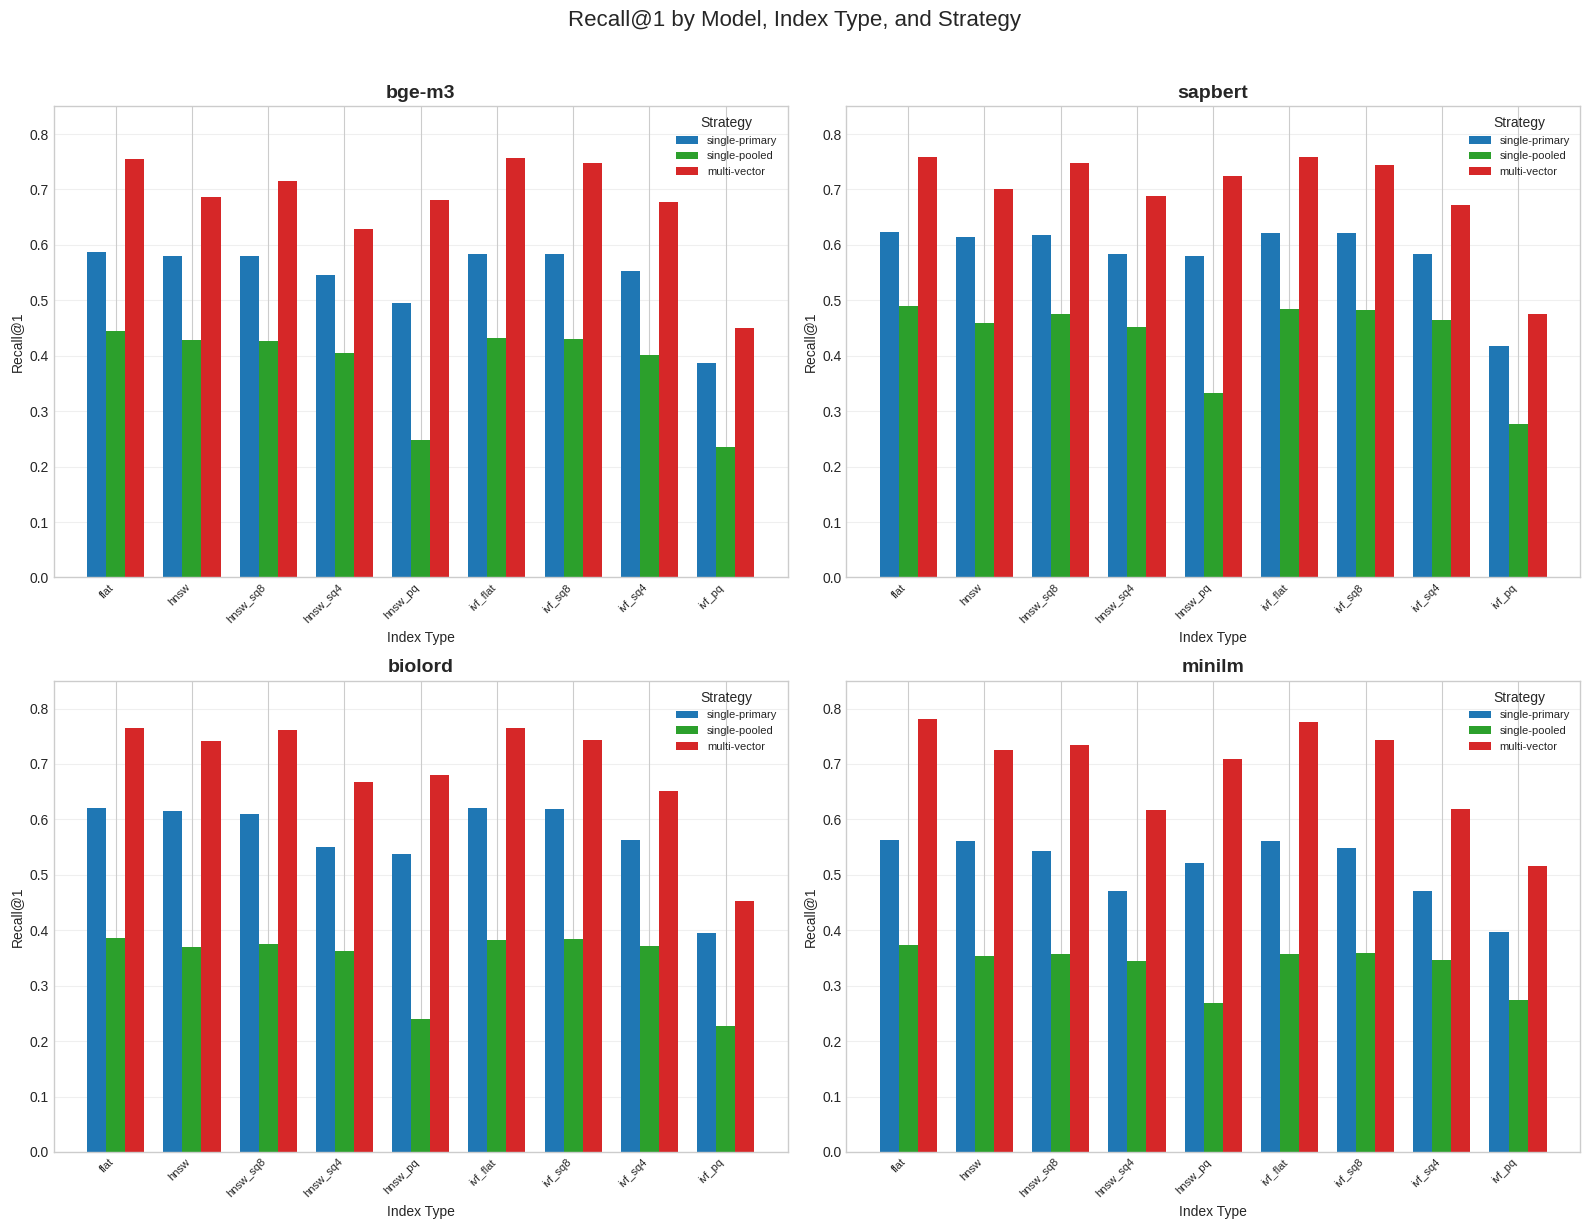

In [9]:
# Recall@1 by Configuration - Faceted Static Chart

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

models = df_valid['model'].unique()
strategies = df_valid['strategy'].unique()
colors = {'single-primary': '#1f77b4', 'single-pooled': '#2ca02c', 'multi-vector': '#d62728'}

for idx, model in enumerate(models):
    if idx >= len(axes):
        break
    ax = axes[idx]
    df_model = df_valid[df_valid['model'] == model]
    
    index_types = df_model['index_type'].unique()
    x = np.arange(len(index_types))
    width = 0.25
    
    for i, strategy in enumerate(strategies):
        subset = df_model[df_model['strategy'] == strategy]
        values = [subset[subset['index_type'] == it]['recall@1'].values[0] 
                  if len(subset[subset['index_type'] == it]) > 0 else 0 
                  for it in index_types]
        ax.bar(x + i*width, values, width, label=strategy, color=colors[strategy])
    
    ax.set_title(f'{model}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Index Type')
    ax.set_ylabel('Recall@1')
    ax.set_xticks(x + width)
    ax.set_xticklabels(index_types, rotation=45, ha='right', fontsize=8)
    ax.set_ylim(0, 0.85)
    ax.legend(title='Strategy', loc='upper right', fontsize=8)
    ax.grid(axis='y', alpha=0.3)

# Hide empty subplot if odd number of models
for idx in range(len(models), len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Recall@1 by Model, Index Type, and Strategy', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'recall_faceted_by_model.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Recall@k Analysis (LLM Re-ranking Potential)

This section analyzes which configurations would benefit most from LLM re-ranking.

**LLM Benefit Score** = (recall@max_k - recall@1) / recall@max_k

- High score (>0.3) means many correct results are in top-k but not ranked first
- These configs are ideal candidates for LLM interpretation/re-ranking

**Extended k Analysis** (when recall@20/50/100 available):
- Track where recall gains plateau
- Identify optimal k for LLM re-ranking (balance between recall and candidates to process)

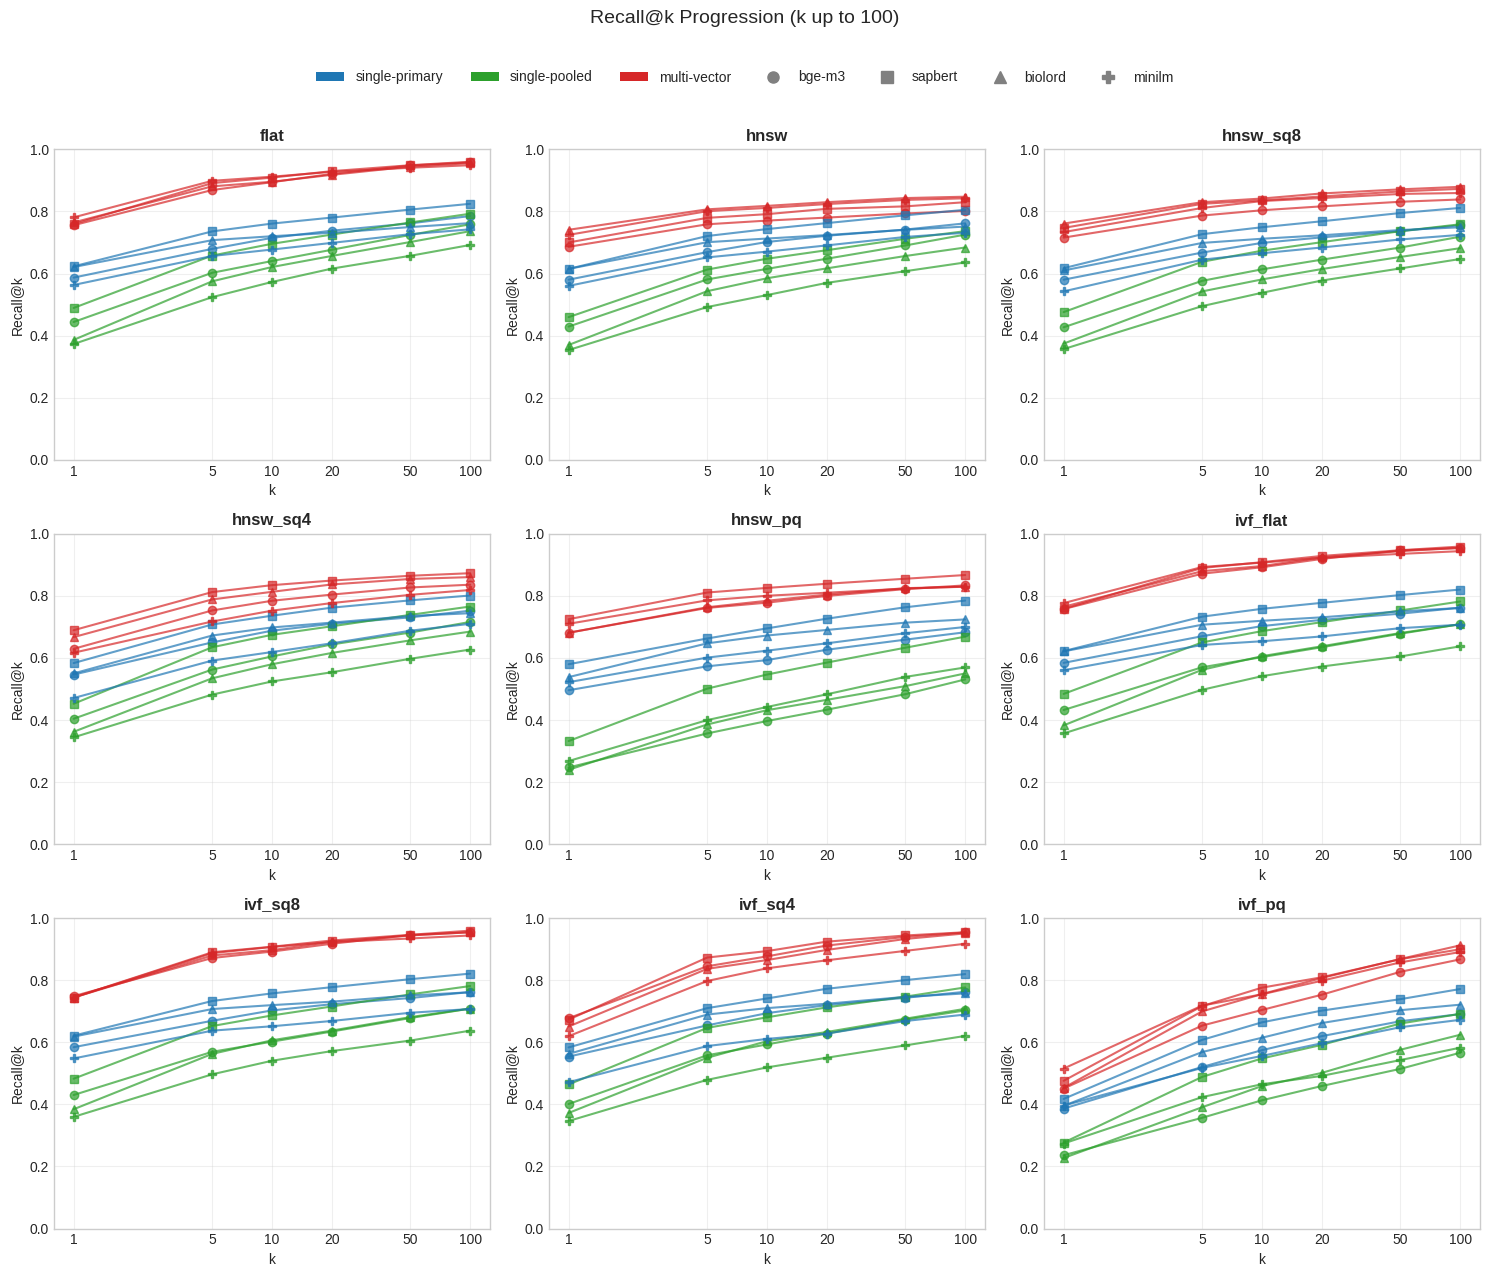

In [10]:
# Recall@k Progression - Static Matplotlib

# Determine available recall columns
if has_extended_k:
    recall_cols = ['recall@1', 'recall@5', 'recall@10', 'recall@20', 'recall@50', 'recall@100']
    k_values = [1, 5, 10, 20, 50, 100]
else:
    recall_cols = ['recall@1', 'recall@5', 'recall@10']
    k_values = [1, 5, 10]

# Create faceted plot by index type
index_types = df_valid['index_type'].unique()
n_cols = 3
n_rows = int(np.ceil(len(index_types) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes.flatten()

strategy_colors = {'single-primary': '#1f77b4', 'single-pooled': '#2ca02c', 'multi-vector': '#d62728'}
model_markers = {'bge-m3': 'o', 'sapbert': 's', 'biolord': '^', 'minilm': 'P'}

for idx, index_type in enumerate(index_types):
    ax = axes[idx]
    df_idx = df_valid[df_valid['index_type'] == index_type]
    
    for _, row in df_idx.iterrows():
        recalls = [row[col] for col in recall_cols]
        ax.plot(k_values, recalls, 
                color=strategy_colors[row['strategy']],
                marker=model_markers.get(row['model'], 'o'),
                markersize=6,
                alpha=0.7,
                linewidth=1.5)
    
    ax.set_title(f'{index_type}', fontsize=12, fontweight='bold')
    ax.set_xlabel('k')
    ax.set_ylabel('Recall@k')
    ax.set_ylim(0, 1)
    if has_extended_k:
        ax.set_xscale('log')
        ax.set_xticks(k_values)
        ax.set_xticklabels([str(k) for k in k_values])
    ax.grid(True, alpha=0.3)

# Hide empty subplots
for idx in range(len(index_types), len(axes)):
    axes[idx].set_visible(False)

# Create legend
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
strategy_handles = [Patch(facecolor=c, label=s) for s, c in strategy_colors.items()]
model_handles = [Line2D([0], [0], marker=m, color='gray', linestyle='', 
                         markersize=8, label=s) for s, m in model_markers.items() if s in df_valid['model'].unique()]

fig.legend(handles=strategy_handles + model_handles, 
           loc='upper center', ncol=len(strategy_handles) + len(model_handles),
           bbox_to_anchor=(0.5, 1.02), fontsize=10)

plt.suptitle(f'Recall@k Progression (k up to {k_values[-1]})', fontsize=14, y=1.06)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'recall_at_k_progression.png', dpi=150, bbox_inches='tight')
plt.show()

In [11]:
# Top Configurations by LLM Benefit Score

# Filter valid (non-zero recall@10) and sort by LLM benefit
df_llm = df_valid[df_valid['recall@10'] > 0.1].copy()
df_llm_sorted = df_llm.sort_values('llm_benefit_score', ascending=False)

print("Top 15 Configurations by LLM Re-ranking Potential:")
print("(High score = correct answers often in top-10 but not top-1)")
print()

top_llm = df_llm_sorted[['model', 'strategy', 'index_type', 'recall@1', 'recall@5', 'recall@10', 'llm_benefit_score']].head(15)
display(top_llm.style.format({'recall@1': '{:.3f}', 'recall@5': '{:.3f}', 'recall@10': '{:.3f}', 'llm_benefit_score': '{:.2%}'}))

Top 15 Configurations by LLM Re-ranking Potential:
(High score = correct answers often in top-10 but not top-1)



,model,strategy,index_type,recall@1,recall@5,recall@10,llm_benefit_score
79,biolord,single-pooled,ivf_pq,0.227,0.391,0.459,63.59%
52,sapbert,single-pooled,ivf_pq,0.277,0.488,0.548,59.96%
25,bge-m3,single-pooled,ivf_pq,0.236,0.357,0.413,58.30%
67,biolord,single-pooled,hnsw_pq,0.240,0.386,0.431,56.40%
13,bge-m3,single-pooled,hnsw_pq,0.247,0.357,0.397,53.42%
106,minilm,single-pooled,ivf_pq,0.274,0.423,0.465,52.98%
94,minilm,single-pooled,hnsw_pq,0.268,0.400,0.442,52.93%
80,biolord,multi-vector,ivf_pq,0.453,0.700,0.755,50.32%
40,sapbert,single-pooled,hnsw_pq,0.332,0.501,0.546,50.28%
26,bge-m3,multi-vector,ivf_pq,0.451,0.654,0.704,47.99%


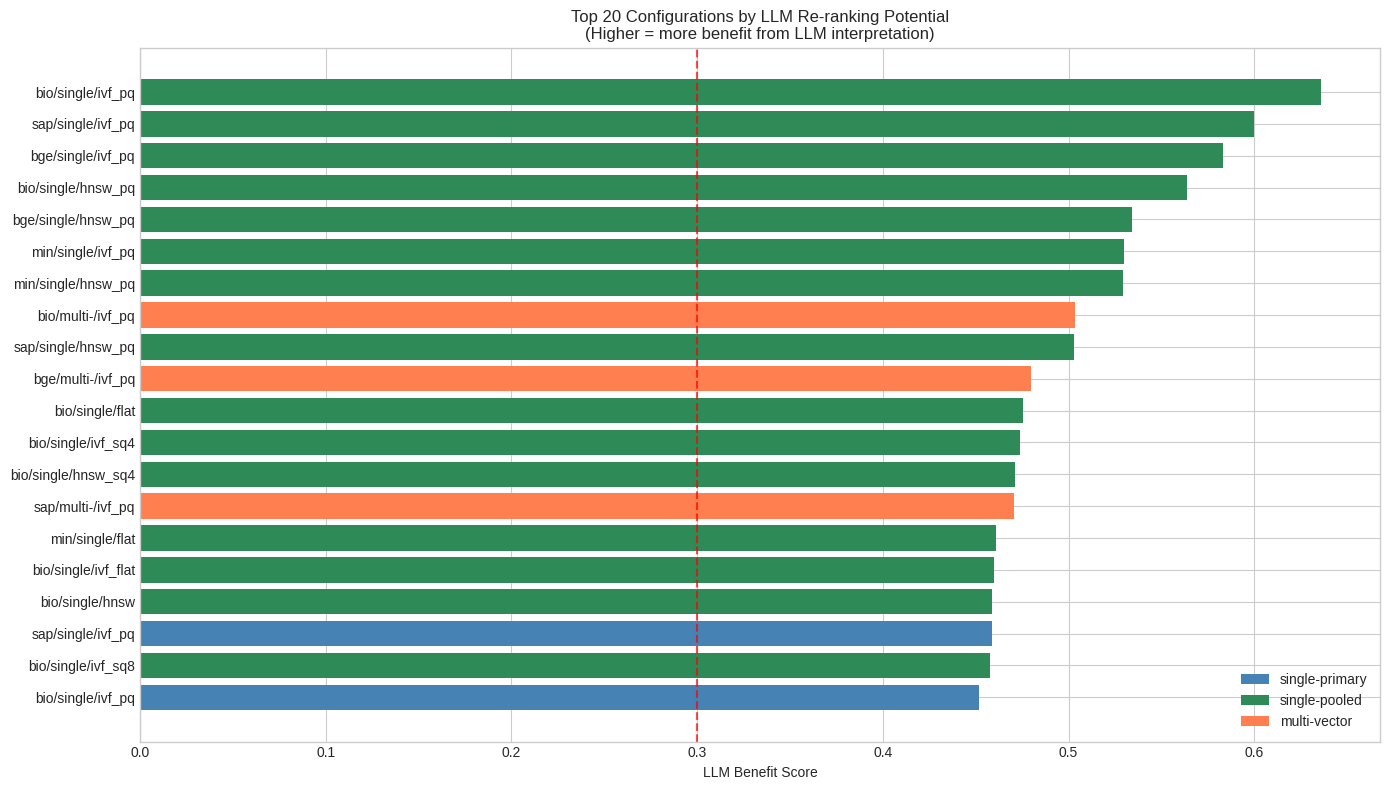

In [12]:
# Bar Chart: LLM Benefit Score by Configuration

fig, ax = plt.subplots(figsize=(14, 8))

top_20 = df_llm_sorted.head(20).copy()
top_20['label'] = top_20['model'].str[:3] + '/' + top_20['strategy'].str[:6] + '/' + top_20['index_type']

colors = top_20['strategy'].map({
    'single-primary': 'steelblue',
    'single-pooled': 'seagreen',
    'multi-vector': 'coral'
})

bars = ax.barh(range(len(top_20)), top_20['llm_benefit_score'], color=colors)
ax.set_yticks(range(len(top_20)))
ax.set_yticklabels(top_20['label'])
ax.set_xlabel('LLM Benefit Score')
ax.set_title('Top 20 Configurations by LLM Re-ranking Potential\n(Higher = more benefit from LLM interpretation)')
ax.axvline(x=0.3, color='red', linestyle='--', alpha=0.7, label='High potential threshold (0.3)')

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='steelblue', label='single-primary'),
    Patch(facecolor='seagreen', label='single-pooled'),
    Patch(facecolor='coral', label='multi-vector'),
]
ax.legend(handles=legend_elements, loc='lower right')

ax.invert_yaxis()
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'llm_benefit_scores.png', dpi=150, bbox_inches='tight')
plt.show()

In [13]:
# Best Configuration at Each k Value

# Build list of k values and their columns
k_values = [1, 5, 10]
if has_extended_k:
    k_values.extend([20, 50, 100])

# Get columns to display
display_cols = ['model', 'strategy', 'index_type'] + [f'recall@{k}' for k in k_values if f'recall@{k}' in df_valid.columns]

best_at_k = []
for k in k_values:
    col = f'recall@{k}'
    if col in df_valid.columns:
        best_row = df_valid.loc[df_valid[col].idxmax()]
        row_dict = {'k': k}
        for c in display_cols:
            row_dict[c] = best_row[c]
        best_at_k.append(row_dict)

best_at_k_df = pd.DataFrame(best_at_k)

print("Best Configuration at Each k Value:")
print("(Note: Best config may differ at higher k - opportunities for LLM re-ranking)")
display(best_at_k_df)

Best Configuration at Each k Value:
(Note: Best config may differ at higher k - opportunities for LLM re-ranking)


,k,model,strategy,index_type,recall@1,recall@5,recall@10,recall@20,recall@50,recall@100
0,1,minilm,multi-vector,flat,0.7809,0.8986,0.9119,0.9275,0.9408,0.9489
1,5,minilm,multi-vector,flat,0.7809,0.8986,0.9119,0.9275,0.9408,0.9489
2,10,minilm,multi-vector,flat,0.7809,0.8986,0.9119,0.9275,0.9408,0.9489
3,20,sapbert,multi-vector,flat,0.7594,0.8912,0.9090,0.9297,0.9489,0.9600
4,50,sapbert,multi-vector,flat,0.7594,0.8912,0.9090,0.9297,0.9489,0.9600
5,100,sapbert,multi-vector,flat,0.7594,0.8912,0.9090,0.9297,0.9489,0.9600


Top 10 Configurations by LLM Headroom (recall@100 - recall@1):


,model,strategy,index_type,recall@1,recall@100,llm_headroom
80,biolord,multi-vector,ivf_pq,0.453,0.912,0.459
53,sapbert,multi-vector,ivf_pq,0.476,0.899,0.423
26,bge-m3,multi-vector,ivf_pq,0.451,0.867,0.416
52,sapbert,single-pooled,ivf_pq,0.277,0.691,0.415
79,biolord,single-pooled,ivf_pq,0.227,0.624,0.397
107,minilm,multi-vector,ivf_pq,0.515,0.890,0.375
51,sapbert,single-primary,ivf_pq,0.417,0.771,0.354
55,biolord,single-pooled,flat,0.386,0.737,0.350
40,sapbert,single-pooled,hnsw_pq,0.332,0.668,0.336
76,biolord,single-pooled,ivf_sq4,0.372,0.708,0.335


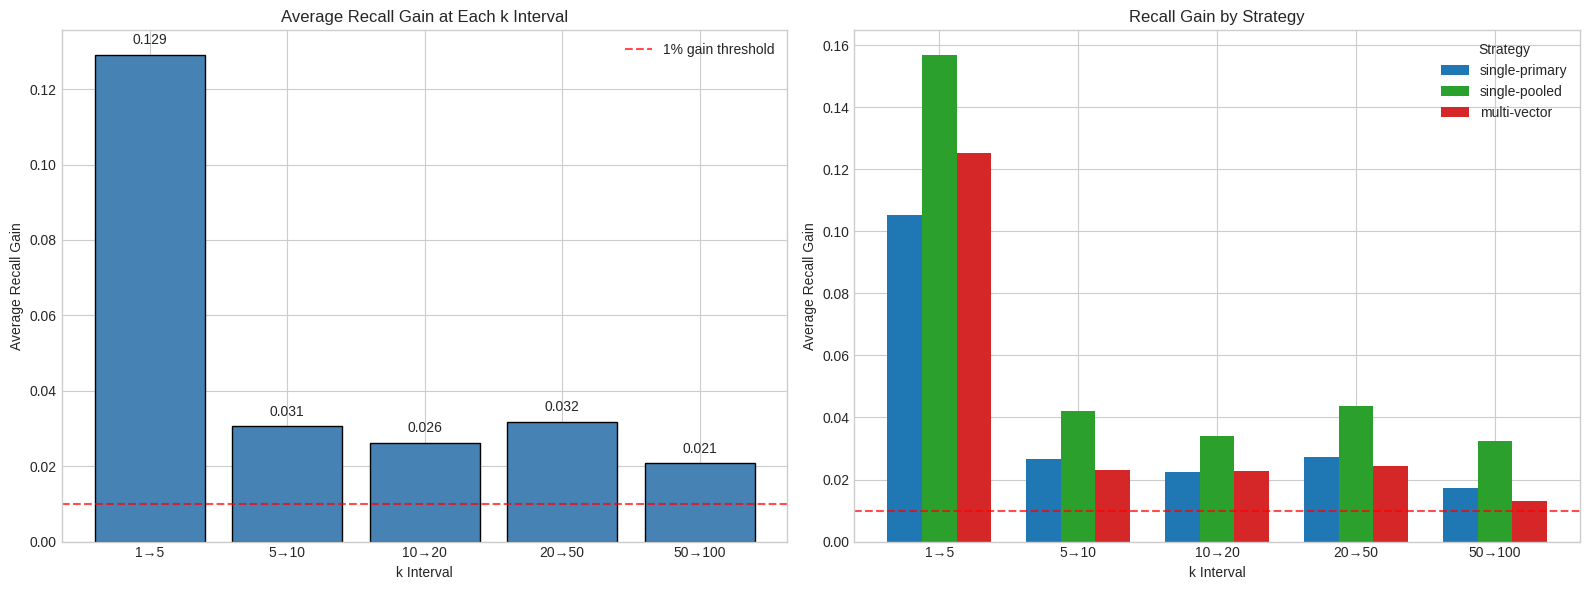


Optimal k Distribution (smallest k where subsequent gain < 1%):
  k=20: 3 configurations (2.8%)
  k=50: 1 configurations (0.9%)
  k=100: 104 configurations (96.3%)

Recommendation for LLM Re-ranking:
  Median optimal k: 100
  Suggestion: Use k=50 for most configurations to capture plateau


In [14]:
# Plateau Analysis: Where does recall stop meaningfully increasing?

if has_extended_k:
    # Compute gains and find plateau point for each config
    gain_cols = ['gain_1_5', 'gain_5_10', 'gain_10_20', 'gain_20_50', 'gain_50_100']
    gain_labels = ['1→5', '5→10', '10→20', '20→50', '50→100']
    
    # Show top configs by total LLM headroom
    print("Top 10 Configurations by LLM Headroom (recall@100 - recall@1):")
    top_headroom = df_valid.nlargest(10, 'llm_headroom')[
        ['model', 'strategy', 'index_type', 'recall@1', 'recall@100', 'llm_headroom']
    ]
    display(top_headroom.style.format({
        'recall@1': '{:.3f}', 'recall@100': '{:.3f}', 'llm_headroom': '{:.3f}'
    }))
    
    # Visualize gains at each step - by strategy
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Left: Average gains across all configs
    ax1 = axes[0]
    avg_gains = df_valid[gain_cols].mean()
    x = np.arange(len(gain_cols))
    bars = ax1.bar(x, avg_gains.values, color='steelblue', edgecolor='black')
    ax1.set_xticks(x)
    ax1.set_xticklabels(gain_labels)
    ax1.set_xlabel('k Interval')
    ax1.set_ylabel('Average Recall Gain')
    ax1.set_title('Average Recall Gain at Each k Interval')
    ax1.axhline(y=0.01, color='red', linestyle='--', alpha=0.7, label='1% gain threshold')
    ax1.legend()
    
    # Add value labels
    for bar, val in zip(bars, avg_gains.values):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002, 
                f'{val:.3f}', ha='center', va='bottom', fontsize=10)
    
    # Right: Gains by strategy
    ax2 = axes[1]
    strategy_colors = {'single-primary': '#1f77b4', 'single-pooled': '#2ca02c', 'multi-vector': '#d62728'}
    width = 0.25
    
    for i, strategy in enumerate(df_valid['strategy'].unique()):
        subset = df_valid[df_valid['strategy'] == strategy]
        gains = subset[gain_cols].mean()
        ax2.bar(x + i*width, gains.values, width, label=strategy, color=strategy_colors[strategy])
    
    ax2.set_xticks(x + width)
    ax2.set_xticklabels(gain_labels)
    ax2.set_xlabel('k Interval')
    ax2.set_ylabel('Average Recall Gain')
    ax2.set_title('Recall Gain by Strategy')
    ax2.axhline(y=0.01, color='red', linestyle='--', alpha=0.7)
    ax2.legend(title='Strategy')
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'recall_plateau_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Find optimal k for each config (smallest k where subsequent gain < 1%)
    def find_optimal_k(row):
        thresholds = [(row['gain_5_10'], 10), (row['gain_10_20'], 20), 
                      (row['gain_20_50'], 50), (row['gain_50_100'], 100)]
        for gain, k in thresholds:
            if gain < 0.01:
                return k
        return 100  # Still gaining at k=100
    
    df_valid['optimal_k'] = df_valid.apply(find_optimal_k, axis=1)
    optimal_k_dist = df_valid['optimal_k'].value_counts().sort_index()
    
    print(f"\nOptimal k Distribution (smallest k where subsequent gain < 1%):")
    for k, count in optimal_k_dist.items():
        print(f"  k={k}: {count} configurations ({count/len(df_valid)*100:.1f}%)")
    
    # Recommendation
    median_optimal_k = df_valid['optimal_k'].median()
    print(f"\nRecommendation for LLM Re-ranking:")
    print(f"  Median optimal k: {median_optimal_k:.0f}")
    print(f"  Suggestion: Use k=50 for most configurations to capture plateau")
else:
    print("Extended k values not available. Re-run evaluation with updated pipeline to see plateau analysis.")

## 4b. Category Breakdown Analysis

Analyze recall performance across query categories to understand which configurations handle different query types best.

**7 Query Categories:**
| Category | Description | Difficulty |
|----------|-------------|------------|
| exact_match | Primary metabolite name | Easy |
| synonym_match | Known synonym lookup | Medium |
| fuzzy_match | Typo/variation queries | Hard |
| greek_letter | Names with alpha, beta, gamma | Hard |
| numeric_prefix | "3-hydroxybutyrate" style | Medium |
| special_prefix | "N-acetyl", "L-carnitine" | Medium |
| **arivale** | Real-world queries from Arivale | Hard |

Per-category metrics detected! Generating comprehensive category breakdown...



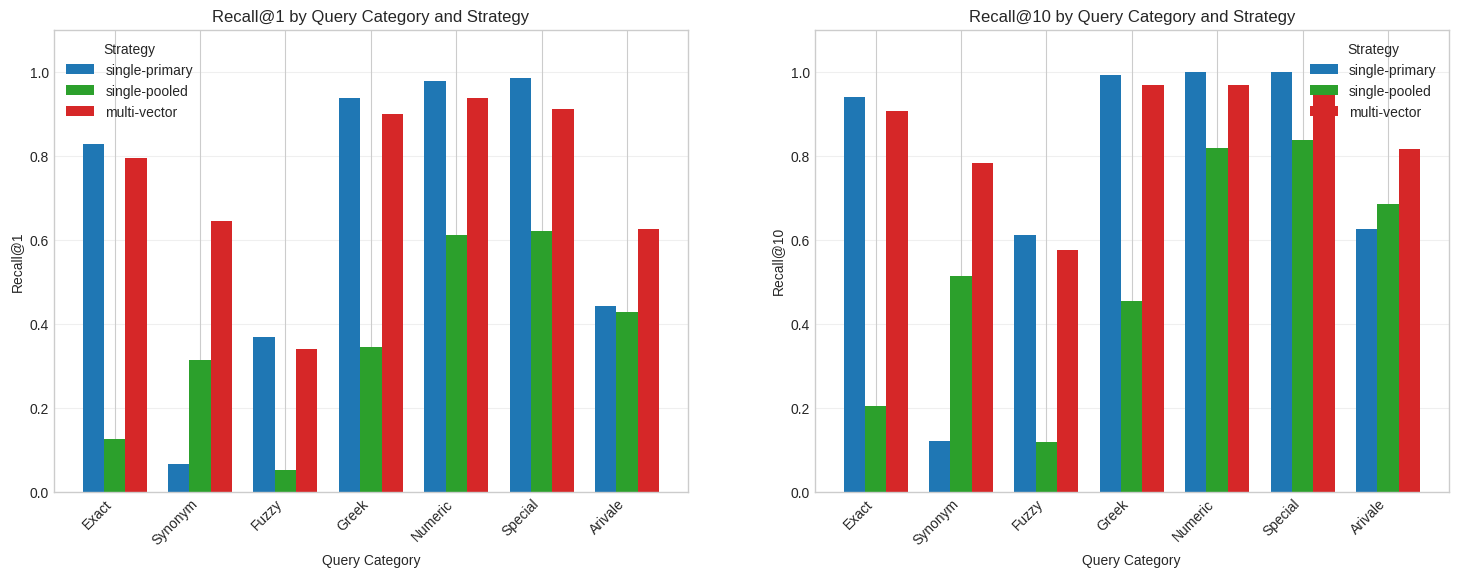

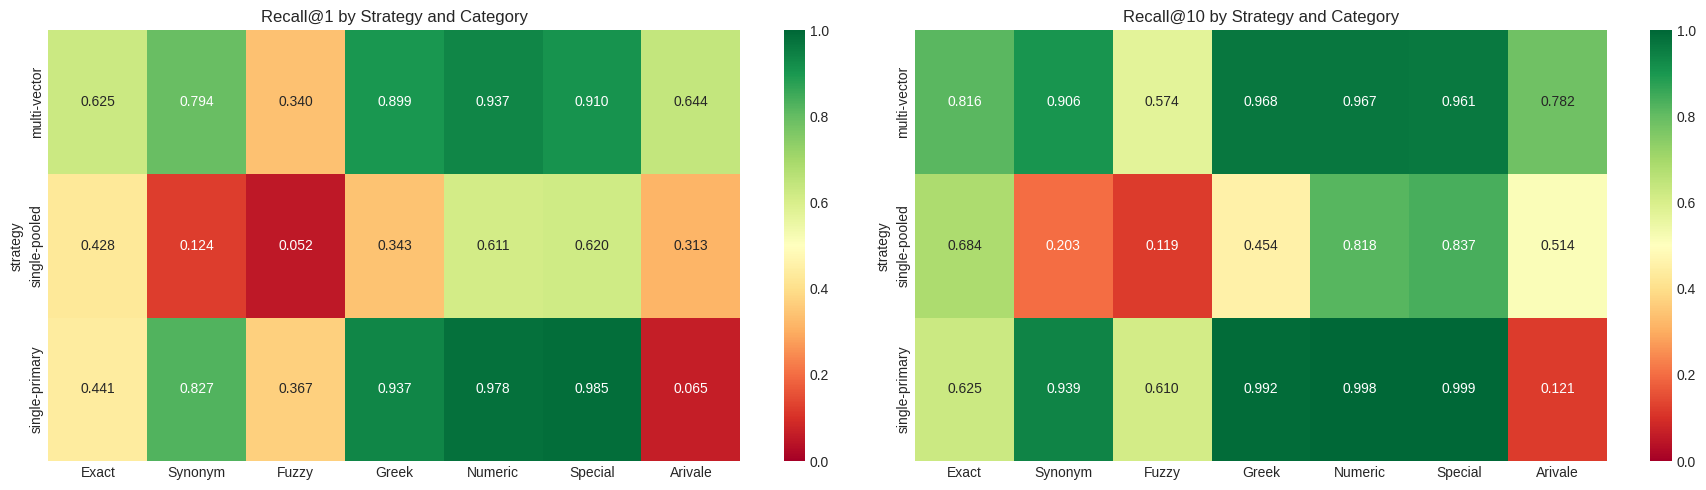


CATEGORY DIFFICULTY HIERARCHY


,Category,Difficulty,Avg R@1,Avg R@10,LLM Gain
0,Exact,Easy,0.582,0.683,0.101
1,Synonym,Medium,0.341,0.472,0.131
2,Fuzzy,Hard,0.253,0.434,0.181
3,Greek,Hard,0.726,0.805,0.078
4,Numeric,Medium,0.842,0.928,0.086
5,Special,Medium,0.838,0.933,0.094
6,Arivale,Hard,0.498,0.708,0.210



BEST CONFIGURATION PER CATEGORY


,Category,Best Model,Best Strategy,Best Index,R@1,R@10
0,Exact,bge-m3,single-primary,flat,1.000,1.000
1,Synonym,bge-m3,multi-vector,flat,0.847,0.860
2,Fuzzy,bge-m3,single-primary,flat,0.540,0.820
3,Greek,bge-m3,single-primary,flat,1.000,1.000
4,Numeric,bge-m3,single-primary,flat,1.000,1.000
5,Special,bge-m3,single-primary,flat,1.000,1.000
6,Arivale,minilm,multi-vector,hnsw_pq,0.733,0.834



IMPROVEMENT OPPORTUNITIES

Categories where R@1 significantly lags (potential for improvement):
  - Synonym: R@1=0.341, R@10=0.472 (gap: 0.131)
  - Fuzzy: R@1=0.253, R@10=0.434 (gap: 0.181)
  - Arivale: R@1=0.498, R@10=0.708 (gap: 0.210)


In [15]:
# Category Breakdown Analysis

# All 7 categories with difficulty labels (including arivale)
CATEGORIES = ['exact_match', 'synonym_match', 'fuzzy_match',
              'greek_letter', 'numeric_prefix', 'special_prefix', 'arivale']
CATEGORY_LABELS = ['Exact', 'Synonym', 'Fuzzy', 'Greek', 'Numeric', 'Special', 'Arivale']
CATEGORY_DIFFICULTY = {
    'exact_match': 'Easy', 'synonym_match': 'Medium', 'fuzzy_match': 'Hard',
    'greek_letter': 'Hard', 'numeric_prefix': 'Medium', 'special_prefix': 'Medium',
    'arivale': 'Hard'  # Real-world queries from Arivale dataset
}

if has_category_metrics:
    print("Per-category metrics detected! Generating comprehensive category breakdown...\n")
    
    # Filter to categories that exist in the data
    available_cats = [c for c in CATEGORIES if f'recall@1_{c}' in df_valid.columns]
    available_labels = [CATEGORY_LABELS[CATEGORIES.index(c)] for c in available_cats]
    
    # 1. Grouped bar chart: Recall@1 by category for each strategy
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    ax1 = axes[0]
    x = np.arange(len(available_cats))
    width = 0.25
    strategy_colors = {'single-primary': '#1f77b4', 'single-pooled': '#2ca02c', 'multi-vector': '#d62728'}
    
    for i, strategy in enumerate(df_valid['strategy'].unique()):
        subset = df_valid[df_valid['strategy'] == strategy]
        means = [subset[f'recall@1_{cat}'].mean() for cat in available_cats]
        ax1.bar(x + i*width, means, width, label=strategy, color=strategy_colors[strategy])
    
    ax1.set_xticks(x + width)
    ax1.set_xticklabels(available_labels, rotation=45, ha='right')
    ax1.set_ylabel('Recall@1')
    ax1.set_xlabel('Query Category')
    ax1.set_title('Recall@1 by Query Category and Strategy')
    ax1.legend(title='Strategy')
    ax1.set_ylim(0, 1.1)
    ax1.grid(axis='y', alpha=0.3)
    
    # 2. Recall@10 by category (complement to first figure)
    ax2 = axes[1]
    for i, strategy in enumerate(df_valid['strategy'].unique()):
        subset = df_valid[df_valid['strategy'] == strategy]
        means = [subset[f'recall@10_{cat}'].mean() for cat in available_cats]  # Changed from gains
        ax2.bar(x + i*width, means, width, label=strategy, color=strategy_colors[strategy])

    ax2.set_xticks(x + width)
    ax2.set_xticklabels(available_labels, rotation=45, ha='right')
    ax2.set_ylabel('Recall@10')  # Changed
    ax2.set_xlabel('Query Category')
    ax2.set_title('Recall@10 by Query Category and Strategy')  # Changed
    ax2.legend(title='Strategy')
    ax2.set_ylim(0, 1.1)  # Added to match first figure
    ax2.grid(axis='y', alpha=0.3)
    
    # 3. Dual heatmap: Strategy × Category for R@1 and R@10
    fig, axes = plt.subplots(1, 2, figsize=(18, 5))
    
    # R@1 heatmap
    cat_cols_r1 = [f'recall@1_{cat}' for cat in available_cats]
    pivot_r1 = df_valid.pivot_table(index='strategy', values=cat_cols_r1, aggfunc='mean')
    pivot_r1.columns = available_labels
    
    sns.heatmap(pivot_r1, annot=True, fmt='.3f', cmap='RdYlGn', ax=axes[0], vmin=0, vmax=1)
    axes[0].set_title('Recall@1 by Strategy and Category')
    
    # R@10 heatmap
    cat_cols_r10 = [f'recall@10_{cat}' for cat in available_cats]
    pivot_r10 = df_valid.pivot_table(index='strategy', values=cat_cols_r10, aggfunc='mean')
    pivot_r10.columns = available_labels
    
    sns.heatmap(pivot_r10, annot=True, fmt='.3f', cmap='RdYlGn', ax=axes[1], vmin=0, vmax=1)
    axes[1].set_title('Recall@10 by Strategy and Category')
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'heatmap_strategy_category.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # 4. Difficulty hierarchy visualization
    print("\n" + "="*60)
    print("CATEGORY DIFFICULTY HIERARCHY")
    print("="*60)
    
    difficulty_stats = []
    for cat, label in zip(available_cats, available_labels):
        avg_r1 = df_valid[f'recall@1_{cat}'].mean()
        avg_r10 = df_valid[f'recall@10_{cat}'].mean()
        difficulty_stats.append({
            'Category': label,
            'Difficulty': CATEGORY_DIFFICULTY[cat],
            'Avg R@1': f"{avg_r1:.3f}",
            'Avg R@10': f"{avg_r10:.3f}",
            'LLM Gain': f"{avg_r10 - avg_r1:.3f}"
        })
    
    difficulty_df = pd.DataFrame(difficulty_stats)
    display(difficulty_df)
    
    # 5. Best configuration for each category
    print("\n" + "="*60)
    print("BEST CONFIGURATION PER CATEGORY")
    print("="*60)
    
    best_by_cat = []
    for cat, label in zip(available_cats, available_labels):
        col_r1 = f'recall@1_{cat}'
        col_r10 = f'recall@10_{cat}'
        best_row = df_valid.loc[df_valid[col_r1].idxmax()]
        best_by_cat.append({
            'Category': label,
            'Best Model': best_row['model'],
            'Best Strategy': best_row['strategy'],
            'Best Index': best_row['index_type'],
            'R@1': f"{best_row[col_r1]:.3f}",
            'R@10': f"{best_row[col_r10]:.3f}",
        })
    
    display(pd.DataFrame(best_by_cat))
    
    # 6. Highlight improvement opportunities
    print("\n" + "="*60)
    print("IMPROVEMENT OPPORTUNITIES")
    print("="*60)
    print("\nCategories where R@1 significantly lags (potential for improvement):")
    for cat, label in zip(available_cats, available_labels):
        avg_r1 = df_valid[f'recall@1_{cat}'].mean()
        if avg_r1 < 0.5:
            avg_r10 = df_valid[f'recall@10_{cat}'].mean()
            print(f"  - {label}: R@1={avg_r1:.3f}, R@10={avg_r10:.3f} (gap: {avg_r10-avg_r1:.3f})")
    
else:
    print("Per-category metrics not available.")
    print("Re-run evaluation with updated pipeline to see category breakdown.")
    print("Expected metrics: recall@1_exact_match, recall@1_synonym_match, etc.")

## 5. Trade-off Scatter Plots

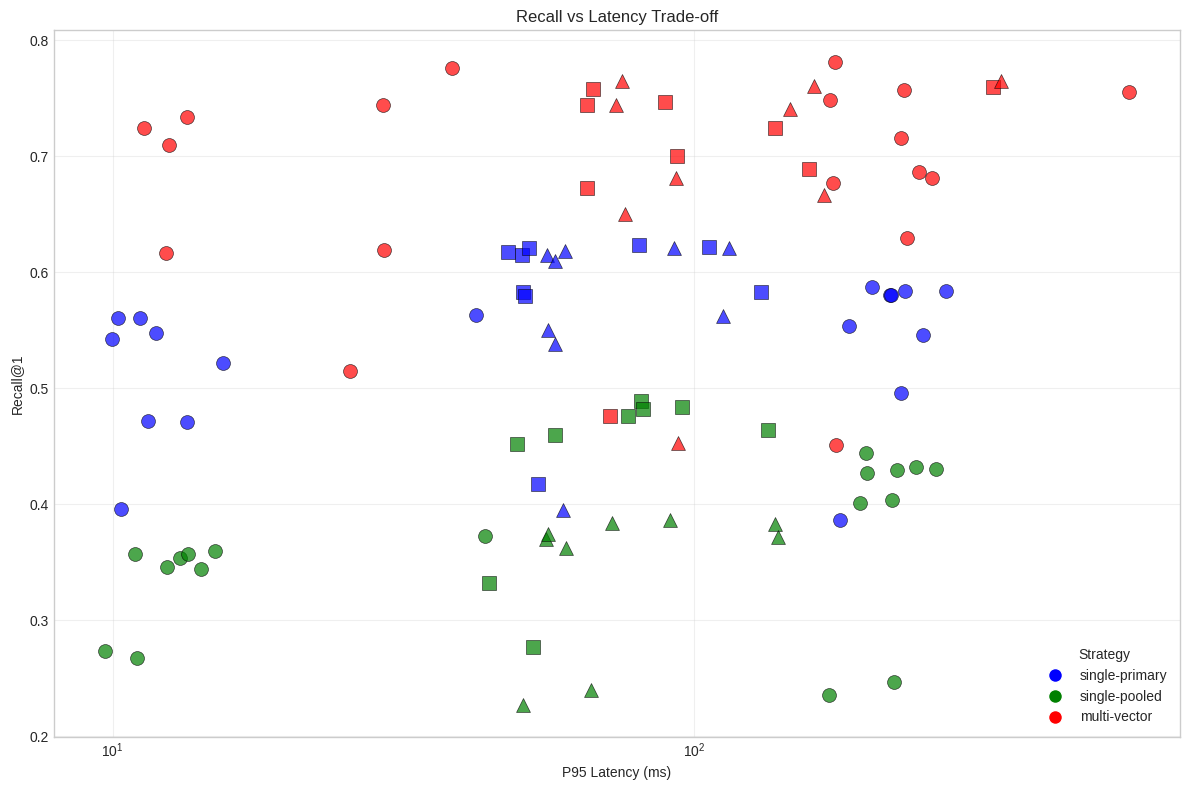

In [16]:
# Recall vs Latency Trade-off (Static)

fig, ax = plt.subplots(figsize=(12, 8))

colors = {'single-primary': 'blue', 'single-pooled': 'green', 'multi-vector': 'red'}
markers = {'bge-m3': 'o', 'sapbert': 's', 'biolord': '^', 'gte-qwen2': 'd'}

for _, row in df_valid.iterrows():
    ax.scatter(
        row['p95_ms'], 
        row['recall@1'],
        c=colors[row['strategy']],
        marker=markers.get(row['model'], 'o'),
        s=100,
        alpha=0.7,
        edgecolors='black',
        linewidth=0.5
    )

ax.set_xlabel('P95 Latency (ms)')
ax.set_ylabel('Recall@1')
ax.set_title('Recall vs Latency Trade-off')
ax.set_xscale('log')
ax.grid(True, alpha=0.3)

# Custom legend
from matplotlib.lines import Line2D
strategy_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=c, 
                           markersize=10, label=s) for s, c in colors.items()]
ax.legend(handles=strategy_handles, title='Strategy', loc='lower right')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'recall_vs_latency.png', dpi=150, bbox_inches='tight')
plt.show()

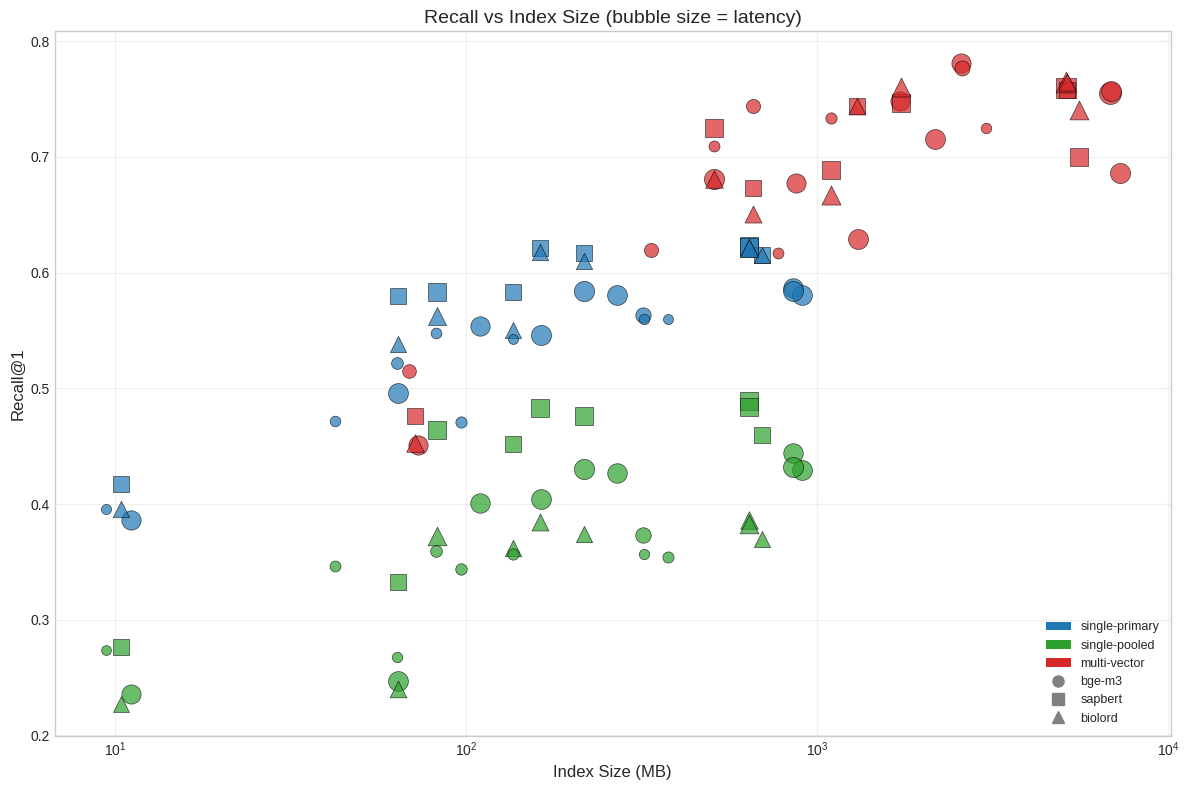

In [17]:
# Recall vs Index Size Trade-off (Static)

fig, ax = plt.subplots(figsize=(12, 8))

colors = {'single-primary': '#1f77b4', 'single-pooled': '#2ca02c', 'multi-vector': '#d62728'}
markers = {'bge-m3': 'o', 'sapbert': 's', 'biolord': '^', 'gte-qwen2': 'd'}

# Calculate size scaling for bubble size based on latency
latency_min = df_valid['p95_ms'].min()
latency_max = df_valid['p95_ms'].max()
size_scale = lambda x: 50 + 200 * (np.log10(x) - np.log10(latency_min)) / (np.log10(latency_max) - np.log10(latency_min) + 0.01)

for _, row in df_valid.iterrows():
    ax.scatter(
        row['index_size_mb'], 
        row['recall@1'],
        c=colors[row['strategy']],
        marker=markers.get(row['model'], 'o'),
        s=size_scale(row['p95_ms']),
        alpha=0.7,
        edgecolors='black',
        linewidth=0.5
    )

ax.set_xlabel('Index Size (MB)', fontsize=12)
ax.set_ylabel('Recall@1', fontsize=12)
ax.set_title('Recall vs Index Size (bubble size = latency)', fontsize=14)
ax.set_xscale('log')
ax.grid(True, alpha=0.3)

# Custom legend for strategies
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
strategy_handles = [Patch(facecolor=c, label=s) for s, c in colors.items()]
model_handles = [Line2D([0], [0], marker=m, color='gray', linestyle='', 
                         markersize=8, label=s) for s, m in markers.items() if s in df_valid['model'].unique()]

ax.legend(handles=strategy_handles + model_handles, 
          loc='lower right', fontsize=9)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'recall_vs_index_size.png', dpi=150, bbox_inches='tight')
plt.show()

In [18]:
# Combined Trade-off Summary Table

print("="*80)
print("TRADE-OFF SUMMARY: Key Metrics by Configuration")
print("="*80)

# Create summary table with key trade-off metrics
summary_cols = ['model', 'strategy', 'index_type', 'recall@1', 'mrr', 'p95_ms', 'index_size_mb']
trade_off_summary = df_valid[summary_cols].copy()
trade_off_summary = trade_off_summary.sort_values('recall@1', ascending=False)

# Add efficiency score (recall per GB per second)
trade_off_summary['efficiency'] = (
    trade_off_summary['recall@1'] / 
    (trade_off_summary['index_size_mb'] / 1000) / 
    (trade_off_summary['p95_ms'] / 1000)
)

print("\nTop 10 by Recall@1:")
display(trade_off_summary.head(10).style.format({
    'recall@1': '{:.3f}', 
    'mrr': '{:.3f}', 
    'p95_ms': '{:.1f}',
    'index_size_mb': '{:.0f}',
    'efficiency': '{:.2f}'
}))

print("\nTop 10 by Efficiency (Recall / Size_GB / Latency_s):")
display(trade_off_summary.nlargest(10, 'efficiency').style.format({
    'recall@1': '{:.3f}', 
    'mrr': '{:.3f}', 
    'p95_ms': '{:.1f}',
    'index_size_mb': '{:.0f}',
    'efficiency': '{:.2f}'
}))

TRADE-OFF SUMMARY: Key Metrics by Configuration

Top 10 by Recall@1:


,model,strategy,index_type,recall@1,mrr,p95_ms,index_size_mb,efficiency
83,minilm,multi-vector,flat,0.781,0.835,174.4,2562,1.75
98,minilm,multi-vector,ivf_flat,0.776,0.830,38.3,2578,7.87
71,biolord,multi-vector,ivf_flat,0.765,0.820,75.1,5142,1.98
56,biolord,multi-vector,flat,0.765,0.820,336.7,5124,0.44
62,biolord,multi-vector,hnsw_sq8,0.761,0.793,160.4,1735,2.73
29,sapbert,multi-vector,flat,0.759,0.821,326.7,5124,0.45
44,sapbert,multi-vector,ivf_flat,0.758,0.819,66.9,5142,2.20
17,bge-m3,multi-vector,ivf_flat,0.757,0.809,229.6,6851,0.48
2,bge-m3,multi-vector,flat,0.756,0.809,558.3,6833,0.20
20,bge-m3,multi-vector,ivf_sq8,0.748,0.805,171.4,1727,2.53



Top 10 by Efficiency (Recall / Size_GB / Latency_s):


,model,strategy,index_type,recall@1,mrr,p95_ms,index_size_mb,efficiency
105,minilm,single-primary,ivf_pq,0.396,0.451,10.3,9,4078.58
106,minilm,single-pooled,ivf_pq,0.274,0.341,9.7,9,3004.26
102,minilm,single-primary,ivf_sq4,0.471,0.525,11.5,42,968.93
51,sapbert,single-primary,ivf_pq,0.417,0.505,53.9,10,745.19
103,minilm,single-pooled,ivf_sq4,0.346,0.409,12.4,42,661.43
78,biolord,single-primary,ivf_pq,0.395,0.474,59.4,10,639.71
99,minilm,single-primary,ivf_sq8,0.548,0.588,11.9,82,560.25
93,minilm,single-primary,hnsw_pq,0.522,0.558,15.5,64,530.48
52,sapbert,single-pooled,ivf_pq,0.277,0.372,52.9,10,503.35
79,biolord,single-pooled,ivf_pq,0.227,0.305,50.7,10,430.67


## 6. Pareto Frontier Analysis

In [19]:
def compute_pareto_frontier(df: pd.DataFrame, 
                            maximize: str, 
                            minimize: str) -> pd.DataFrame:
    """Compute Pareto-optimal configurations.
    
    Args:
        df: DataFrame with results
        maximize: Column to maximize (e.g., 'recall@1')
        minimize: Column to minimize (e.g., 'p95_ms')
    
    Returns:
        DataFrame with only Pareto-optimal rows
    """
    df_sorted = df.sort_values(minimize).reset_index(drop=True)
    pareto_mask = []
    
    max_so_far = -np.inf
    for _, row in df_sorted.iterrows():
        val = row[maximize]
        if val > max_so_far:
            pareto_mask.append(True)
            max_so_far = val
        else:
            pareto_mask.append(False)
    
    return df_sorted[pareto_mask]

# Pareto frontier for recall vs latency
pareto_recall_latency = compute_pareto_frontier(df_valid, 'recall@1', 'p95_ms')
print(f"Pareto-optimal configurations (recall@1 vs latency): {len(pareto_recall_latency)}")
display(pareto_recall_latency[['model', 'strategy', 'index_type', 'recall@1', 'p95_ms', 'index_size_mb']])

Pareto-optimal configurations (recall@1 vs latency): 8


,model,strategy,index_type,recall@1,p95_ms,index_size_mb
0,minilm,single-pooled,ivf_pq,0.2739,9.699,9.4
1,minilm,single-primary,hnsw_sq8,0.5426,9.980,136.4
2,minilm,single-primary,hnsw,0.5603,10.193,375.8
7,minilm,multi-vector,hnsw,0.7246,11.313,3016.2
15,minilm,multi-vector,hnsw_sq8,0.7335,13.430,1094.5
21,minilm,multi-vector,ivf_sq8,0.7439,29.207,655.8
23,minilm,multi-vector,ivf_flat,0.7765,38.294,2577.5
81,minilm,multi-vector,flat,0.7809,174.395,2562.2


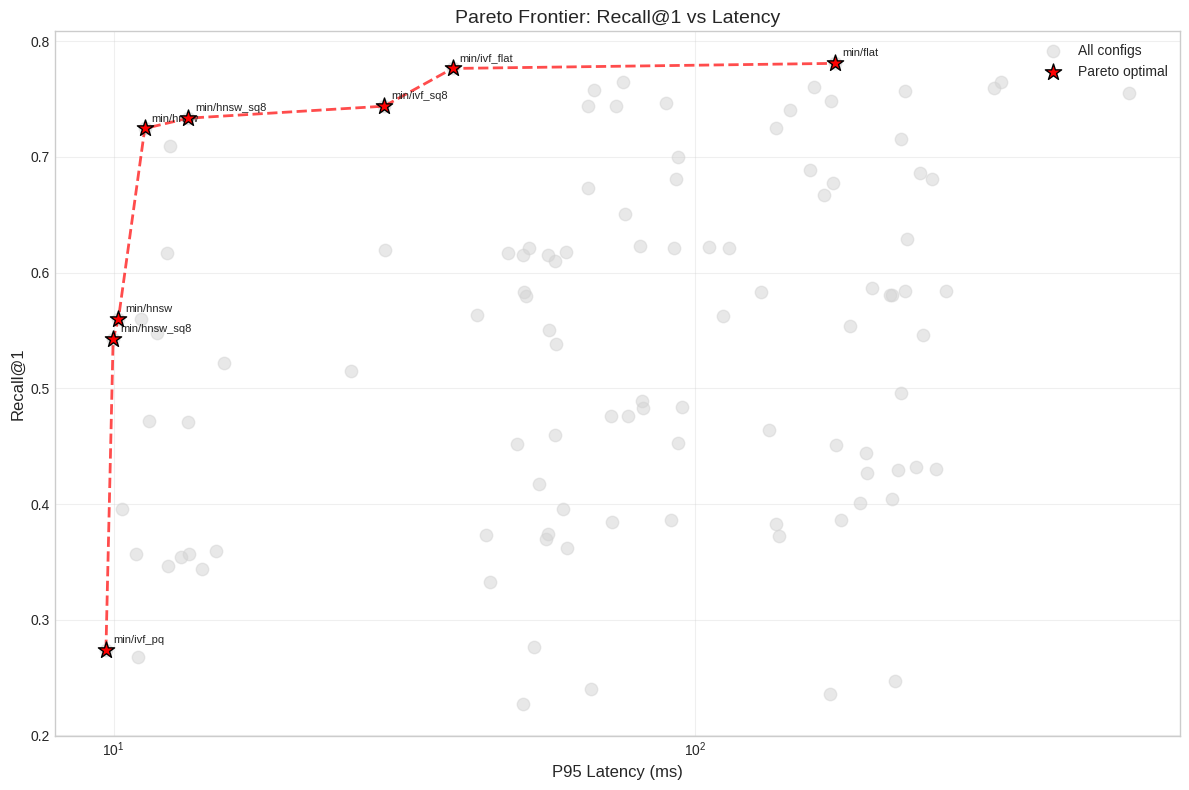

In [20]:
# Pareto Frontier Visualization

fig, ax = plt.subplots(figsize=(12, 8))

# All points
ax.scatter(df_valid['p95_ms'], df_valid['recall@1'], 
           c='lightgray', s=80, alpha=0.5, label='All configs')

# Pareto frontier points
ax.scatter(pareto_recall_latency['p95_ms'], pareto_recall_latency['recall@1'],
           c='red', s=150, marker='*', edgecolors='black', 
           linewidth=1, label='Pareto optimal', zorder=5)

# Connect Pareto points
pareto_sorted = pareto_recall_latency.sort_values('p95_ms')
ax.plot(pareto_sorted['p95_ms'], pareto_sorted['recall@1'], 
        'r--', alpha=0.7, linewidth=2)

# Annotate Pareto points
for _, row in pareto_recall_latency.iterrows():
    label = f"{row['model'][:3]}/{row['index_type']}"
    ax.annotate(label, (row['p95_ms'], row['recall@1']),
                xytext=(5, 5), textcoords='offset points', fontsize=8)

ax.set_xlabel('P95 Latency (ms)', fontsize=12)
ax.set_ylabel('Recall@1', fontsize=12)
ax.set_title('Pareto Frontier: Recall@1 vs Latency', fontsize=14)
ax.set_xscale('log')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'pareto_frontier.png', dpi=150, bbox_inches='tight')
plt.show()

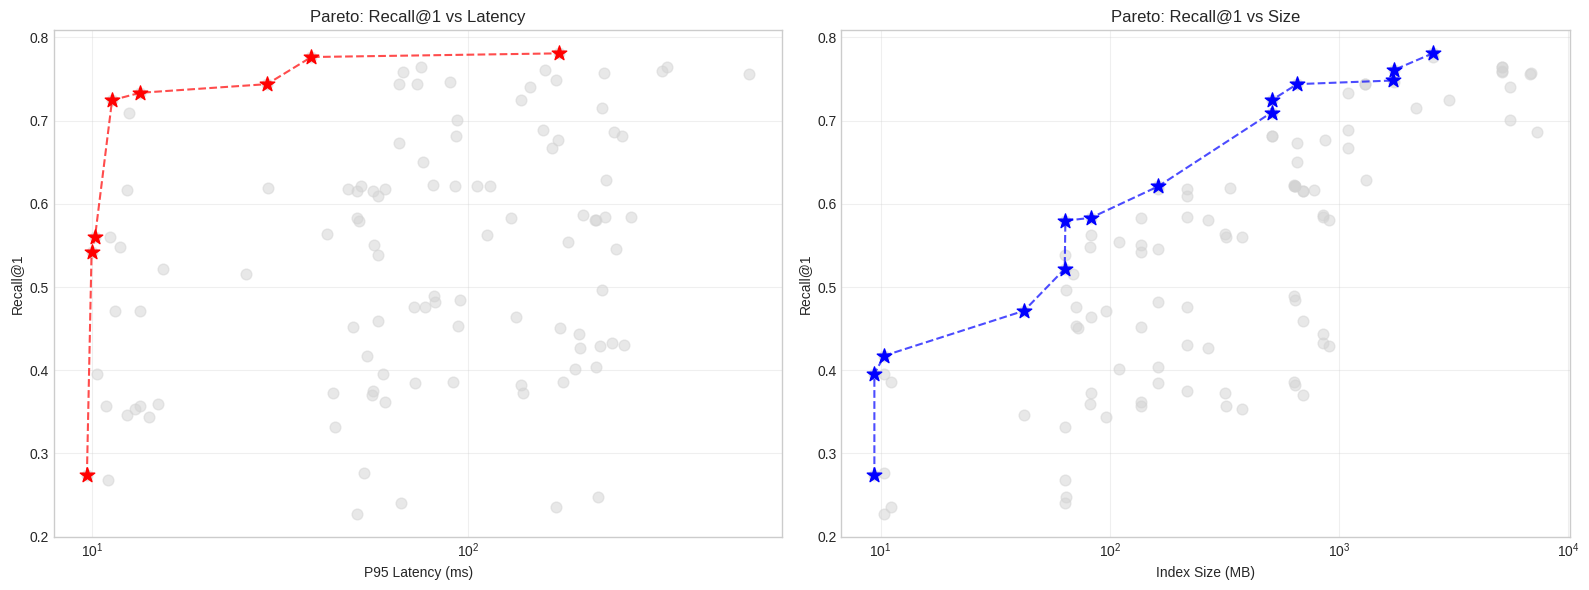

In [21]:
# Multi-Objective Pareto Analysis (Recall vs Latency AND Recall vs Size)

pareto_recall_size = compute_pareto_frontier(df_valid, 'recall@1', 'index_size_mb')

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Recall vs Latency Pareto
ax1 = axes[0]
ax1.scatter(df_valid['p95_ms'], df_valid['recall@1'], c='lightgray', s=60, alpha=0.5)
ax1.scatter(pareto_recall_latency['p95_ms'], pareto_recall_latency['recall@1'],
            c='red', s=120, marker='*', zorder=5)
pareto_sorted = pareto_recall_latency.sort_values('p95_ms')
ax1.plot(pareto_sorted['p95_ms'], pareto_sorted['recall@1'], 'r--', alpha=0.7)
ax1.set_xlabel('P95 Latency (ms)')
ax1.set_ylabel('Recall@1')
ax1.set_title('Pareto: Recall@1 vs Latency')
ax1.set_xscale('log')
ax1.grid(True, alpha=0.3)

# Recall vs Size Pareto
ax2 = axes[1]
ax2.scatter(df_valid['index_size_mb'], df_valid['recall@1'], c='lightgray', s=60, alpha=0.5)
ax2.scatter(pareto_recall_size['index_size_mb'], pareto_recall_size['recall@1'],
            c='blue', s=120, marker='*', zorder=5)
pareto_sorted = pareto_recall_size.sort_values('index_size_mb')
ax2.plot(pareto_sorted['index_size_mb'], pareto_sorted['recall@1'], 'b--', alpha=0.7)
ax2.set_xlabel('Index Size (MB)')
ax2.set_ylabel('Recall@1')
ax2.set_title('Pareto: Recall@1 vs Size')
ax2.set_xscale('log')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'pareto_combined.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Heatmaps

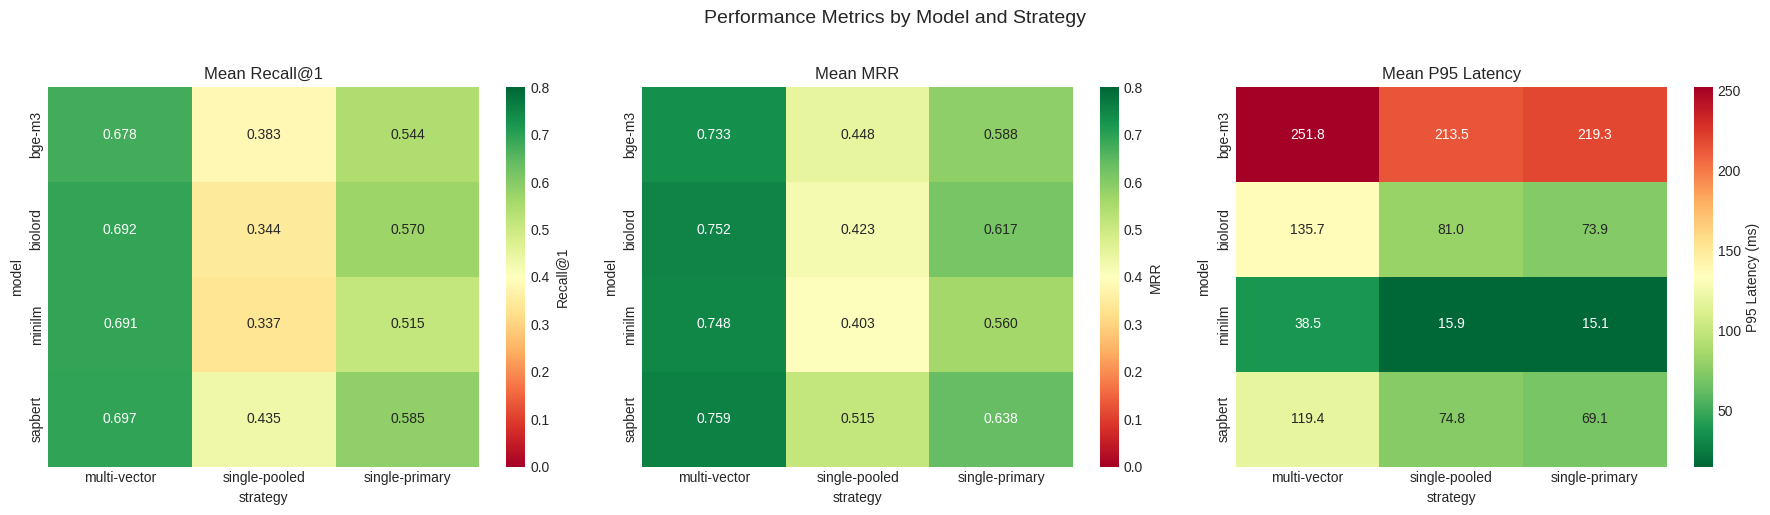

In [22]:
# Model x Strategy Heatmap

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Recall@1 heatmap
pivot_recall = df_valid.pivot_table(
    index='model', 
    columns='strategy', 
    values='recall@1', 
    aggfunc='mean'
)
sns.heatmap(pivot_recall, annot=True, fmt='.3f', cmap='RdYlGn', 
            ax=axes[0], vmin=0, vmax=0.8, cbar_kws={'label': 'Recall@1'})
axes[0].set_title('Mean Recall@1')

# MRR heatmap
pivot_mrr = df_valid.pivot_table(
    index='model', 
    columns='strategy', 
    values='mrr', 
    aggfunc='mean'
)
sns.heatmap(pivot_mrr, annot=True, fmt='.3f', cmap='RdYlGn', 
            ax=axes[1], vmin=0, vmax=0.8, cbar_kws={'label': 'MRR'})
axes[1].set_title('Mean MRR')

# Latency heatmap
pivot_latency = df_valid.pivot_table(
    index='model', 
    columns='strategy', 
    values='p95_ms', 
    aggfunc='mean'
)
sns.heatmap(pivot_latency, annot=True, fmt='.1f', cmap='RdYlGn_r', 
            ax=axes[2], cbar_kws={'label': 'P95 Latency (ms)'})
axes[2].set_title('Mean P95 Latency')

plt.suptitle('Performance Metrics by Model and Strategy', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'heatmap_model_strategy.png', dpi=150, bbox_inches='tight')
plt.show()

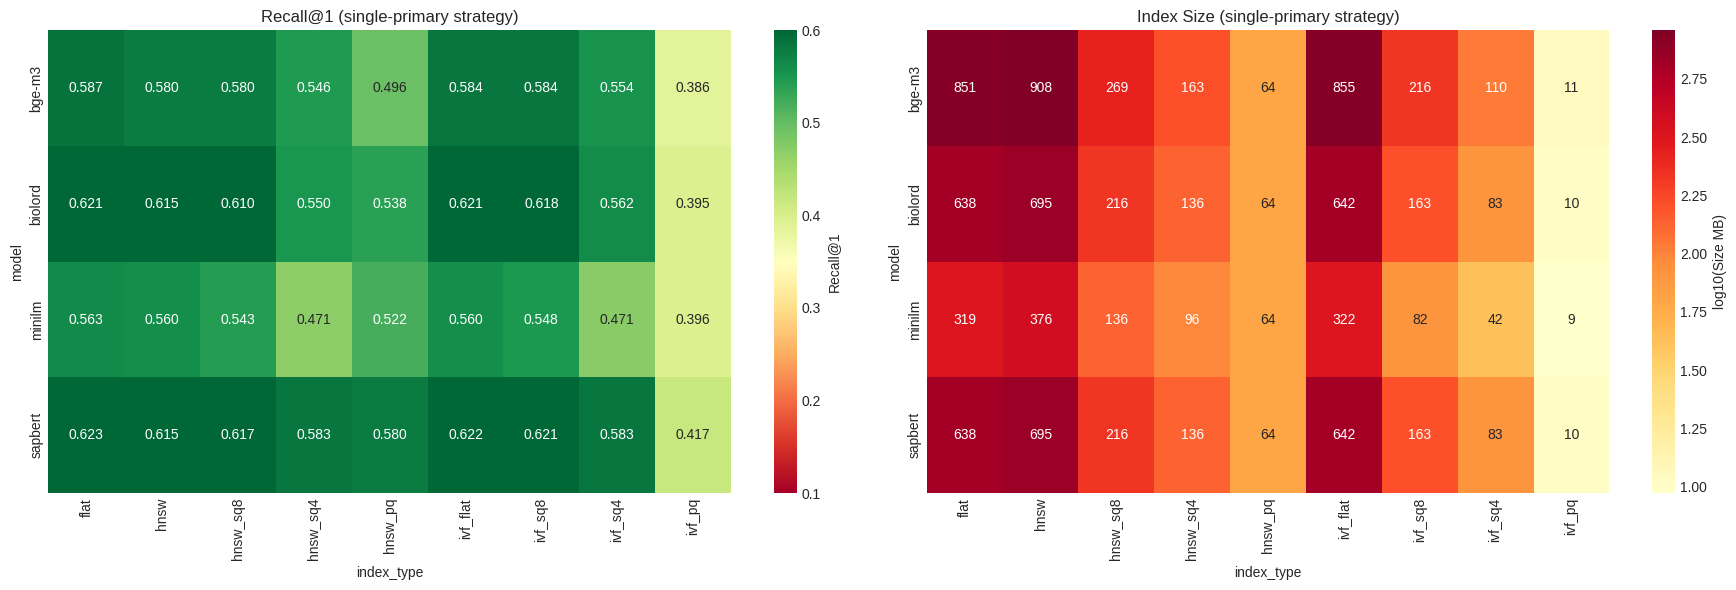

In [23]:
# Model x Index Type Heatmap (single-primary strategy only)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

df_primary = df_valid[df_valid['strategy'] == 'single-primary']

# Recall@1 by model and index type
pivot_recall = df_primary.pivot_table(
    index='model', 
    columns='index_type', 
    values='recall@1', 
    aggfunc='mean'
)
# Reorder index types logically (only include those present in data)
index_order = ['flat', 'hnsw', 'hnsw_sq8', 'hnsw_sq4', 'hnsw_pq',
               'ivf_flat', 'ivf_sq8', 'ivf_sq4', 'ivf_pq']
available_cols = [c for c in index_order if c in pivot_recall.columns]
pivot_recall = pivot_recall.reindex(columns=available_cols)

sns.heatmap(pivot_recall, annot=True, fmt='.3f', cmap='RdYlGn', 
            ax=axes[0], vmin=0.1, vmax=0.6, cbar_kws={'label': 'Recall@1'})
axes[0].set_title('Recall@1 (single-primary strategy)')

# Index size heatmap
pivot_size = df_primary.pivot_table(
    index='model', 
    columns='index_type', 
    values='index_size_mb', 
    aggfunc='mean'
)
pivot_size = pivot_size.reindex(columns=available_cols)

# Handle NaN values by filling with empty string for display
annot_df = pivot_size.fillna(0).round(0).astype(int).astype(str)
annot_df = annot_df.replace('0', '')  # Replace filled zeros with empty string

sns.heatmap(np.log10(pivot_size.fillna(1)), annot=annot_df, 
            fmt='', cmap='YlOrRd', ax=axes[1], cbar_kws={'label': 'log10(Size MB)'},
            mask=pivot_size.isna())  # Mask NaN cells
axes[1].set_title('Index Size (single-primary strategy)')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'heatmap_model_index.png', dpi=150, bbox_inches='tight')
plt.show()

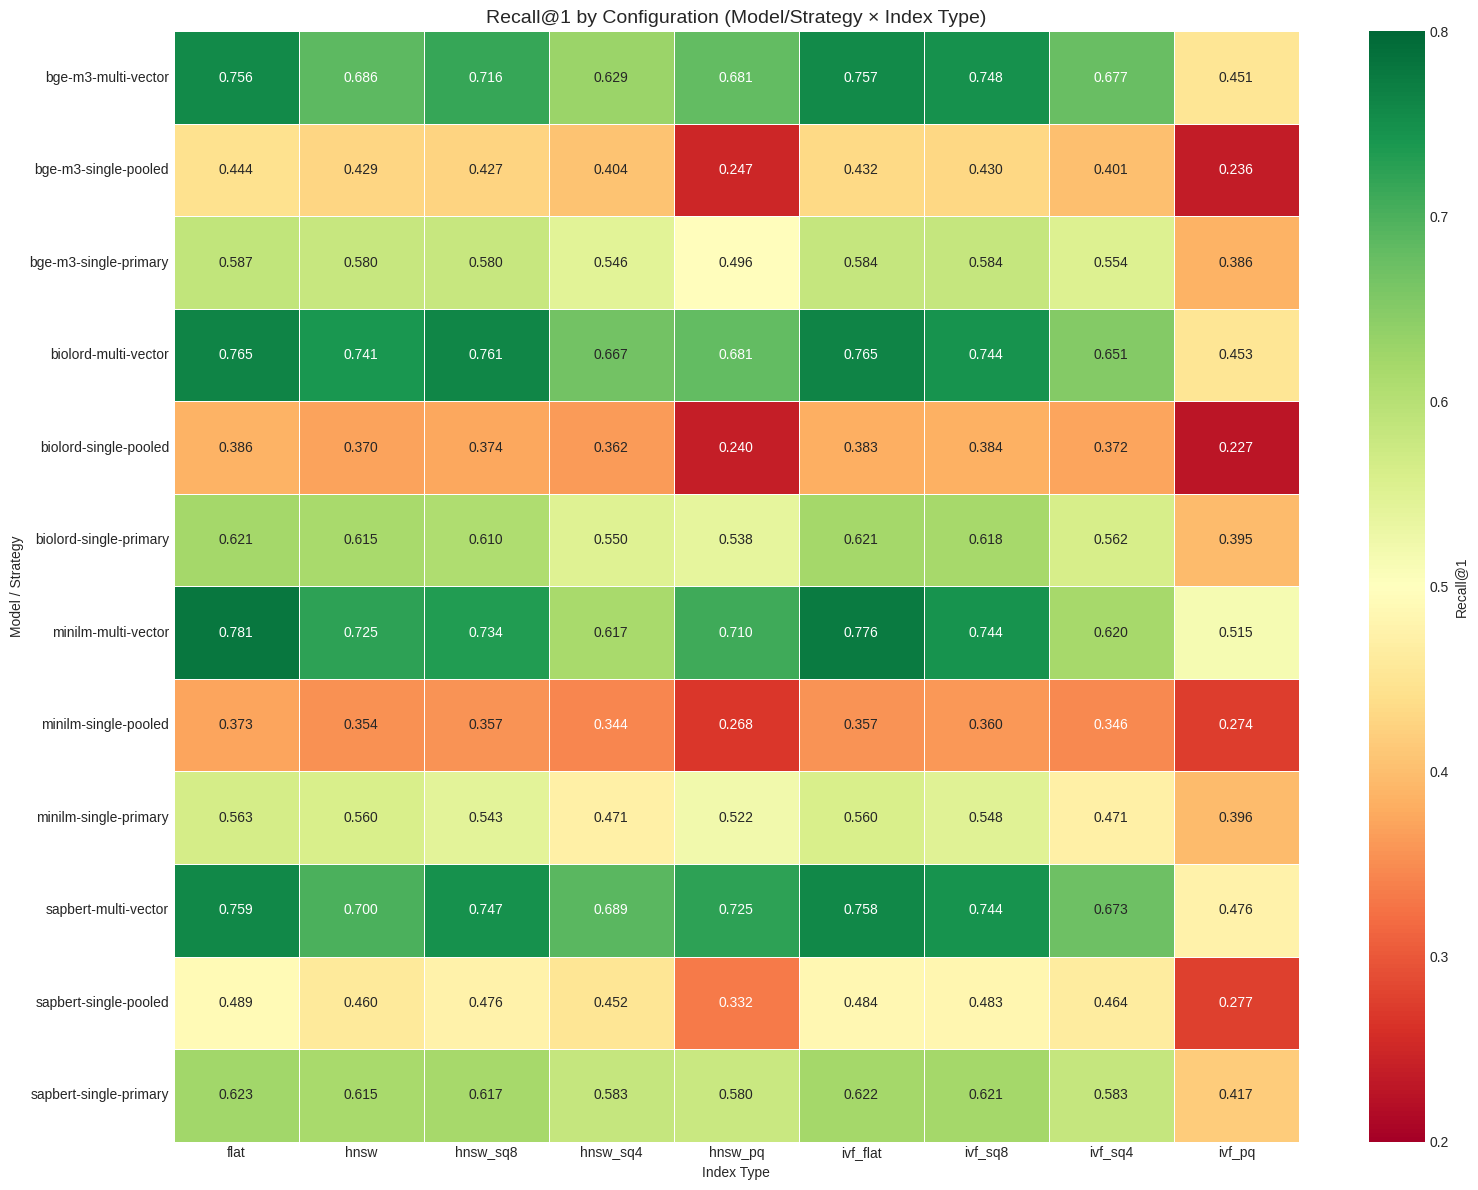

In [24]:
# Comprehensive Heatmap: All Configurations

# Create a complete heatmap of model+strategy vs index_type
pivot_all = df_valid.pivot_table(
    index=['model', 'strategy'],
    columns='index_type',
    values='recall@1',
    aggfunc='mean'
)

# Reorder index types (9 total)
index_order = ['flat', 'hnsw', 'hnsw_sq8', 'hnsw_sq4', 'hnsw_pq',
               'ivf_flat', 'ivf_sq8', 'ivf_sq4', 'ivf_pq']
pivot_all = pivot_all.reindex(columns=[c for c in index_order if c in pivot_all.columns])

fig, ax = plt.subplots(figsize=(16, 12))

sns.heatmap(pivot_all, annot=True, fmt='.3f', cmap='RdYlGn', 
            ax=ax, vmin=0.2, vmax=0.8, cbar_kws={'label': 'Recall@1'},
            linewidths=0.5)

ax.set_title('Recall@1 by Configuration (Model/Strategy × Index Type)', fontsize=14)
ax.set_xlabel('Index Type')
ax.set_ylabel('Model / Strategy')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'heatmap_all_configs.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Model Comparison Analysis

This section analyzes how similar the different embedding models perform across configurations.
The key finding is that models perform remarkably similarly - the choice of strategy and index type
matters more than the choice of model.

MODEL COMPARISON ANALYSIS

1. Model Recall@1 Correlation Matrix:

Correlation between models (very high = models perform similarly):


model,bge-m3,biolord,minilm,sapbert
model,,,,
bge-m3,1.0000,0.9829,0.9617,0.9916
biolord,0.9829,1.0000,0.9731,0.9829
minilm,0.9617,0.9731,1.0000,0.9537
sapbert,0.9916,0.9829,0.9537,1.0000



2. Recall@1 Variance Across Models:

Variance by Strategy/Index (low std/range = models are similar):


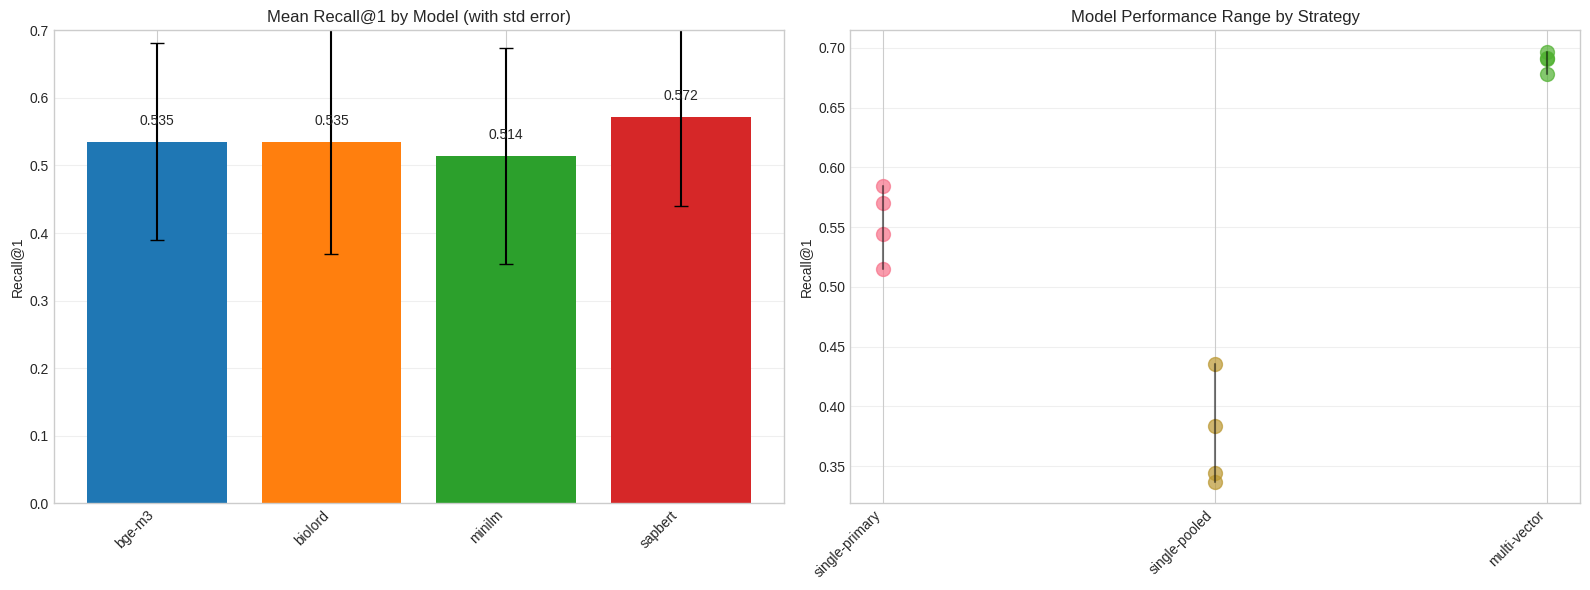


KEY INSIGHT
Average recall range across models: 0.0744
Models perform very similarly (range < 0.02 in most cases).
Strategy and index type selection matter more than model choice.


In [25]:
# Model Similarity Analysis

print("="*70)
print("MODEL COMPARISON ANALYSIS")
print("="*70)

# 1. Model-to-model correlation
print("\n1. Model Recall@1 Correlation Matrix:")
model_recall_pivot = df_valid.pivot_table(
    index=['strategy', 'index_type'],
    columns='model',
    values='recall@1'
)
correlation = model_recall_pivot.corr()
print(f"\nCorrelation between models (very high = models perform similarly):")
display(correlation.style.format('{:.4f}'))

# 2. Variance across models
print("\n2. Recall@1 Variance Across Models:")
model_variance = df_valid.groupby(['strategy', 'index_type']).agg({
    'recall@1': ['mean', 'std', 'min', 'max']
}).round(4)
model_variance.columns = ['Mean R@1', 'Std R@1', 'Min R@1', 'Max R@1']
model_variance['Range'] = model_variance['Max R@1'] - model_variance['Min R@1']
print("\nVariance by Strategy/Index (low std/range = models are similar):")
display(model_variance.style.format('{:.4f}'))

# 3. Visualization: Model comparison bar chart
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Mean recall by model
ax1 = axes[0]
model_means = df_valid.groupby('model')['recall@1'].agg(['mean', 'std'])
x = np.arange(len(model_means))
bars = ax1.bar(x, model_means['mean'], yerr=model_means['std'], 
               capsize=5, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'][:len(model_means)])
ax1.set_xticks(x)
ax1.set_xticklabels(model_means.index, rotation=45, ha='right')
ax1.set_ylabel('Recall@1')
ax1.set_title('Mean Recall@1 by Model (with std error)')
ax1.set_ylim(0, 0.7)
ax1.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{height:.3f}', ha='center', va='bottom', fontsize=10)

# Right: Model performance range by strategy
ax2 = axes[1]
for i, strategy in enumerate(df_valid['strategy'].unique()):
    subset = df_valid[df_valid['strategy'] == strategy]
    model_recalls = subset.groupby('model')['recall@1'].mean()
    ax2.scatter([i]*len(model_recalls), model_recalls.values, 
                s=100, alpha=0.7, label=strategy if i == 0 else "")
    # Draw range line
    ax2.plot([i, i], [model_recalls.min(), model_recalls.max()], 'k-', alpha=0.5)

ax2.set_xticks(range(len(df_valid['strategy'].unique())))
ax2.set_xticklabels(df_valid['strategy'].unique(), rotation=45, ha='right')
ax2.set_ylabel('Recall@1')
ax2.set_title('Model Performance Range by Strategy')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Summary insight
avg_range = model_variance['Range'].mean()
print(f"\n" + "="*70)
print("KEY INSIGHT")
print("="*70)
print(f"Average recall range across models: {avg_range:.4f}")
print(f"Models perform very similarly (range < 0.02 in most cases).")
print(f"Strategy and index type selection matter more than model choice.")

In [26]:
# Compression Trade-off Analysis

print("="*70)
print("COMPRESSION TRADE-OFF ANALYSIS")
print("="*70)

# Compare index types by compression level
compression_stats = df_valid.groupby('index_type').agg({
    'recall@1': ['mean', 'std'],
    'p95_ms': ['mean', 'min'],
    'index_size_mb': ['mean', 'min', 'max']
}).round(3)

compression_stats.columns = ['R@1 Mean', 'R@1 Std', 'P95 Mean', 'P95 Min', 'Size Mean', 'Size Min', 'Size Max']

print("\nIndex Type Comparison:")
display(compression_stats)

# Compression ratio relative to flat
flat_size = df_valid[df_valid['index_type'] == 'flat']['index_size_mb'].mean()
compression_stats['Compression Ratio'] = flat_size / compression_stats['Size Mean']

print(f"\nCompression Ratios (relative to flat index at {flat_size:.0f}MB avg):")
for idx, row in compression_stats.iterrows():
    ratio = row['Compression Ratio']
    r1 = row['R@1 Mean']
    print(f"  {idx}: {ratio:.1f}x compression, R@1={r1:.3f}")

COMPRESSION TRADE-OFF ANALYSIS

Index Type Comparison:


,R@1 Mean,R@1 Std,P95 Mean,P95 Min,Size Mean,Size Min,Size Max
index_type,,,,,,,
flat,0.596,0.149,185.489,42.183,2044.850,319.2,6832.6
hnsw,0.570,0.137,98.097,10.193,2233.900,375.8,7286.6
hnsw_pq,0.502,0.186,99.368,11.020,211.983,63.6,508.3
hnsw_sq4,0.526,0.118,106.616,12.359,444.658,96.5,1308.1
hnsw_sq8,0.578,0.145,97.297,9.980,700.267,136.4,2162.1
ivf_flat,0.592,0.153,113.011,10.925,2052.550,321.6,6851.1
ivf_pq,0.375,0.098,79.327,9.699,30.608,9.4,72.9
ivf_sq4,0.531,0.118,105.010,11.504,263.283,42.3,872.6
ivf_sq8,0.584,0.145,96.850,11.893,518.875,82.2,1726.7



Compression Ratios (relative to flat index at 2045MB avg):
  flat: 1.0x compression, R@1=0.596
  hnsw: 0.9x compression, R@1=0.570
  hnsw_pq: 9.6x compression, R@1=0.502
  hnsw_sq4: 4.6x compression, R@1=0.526
  hnsw_sq8: 2.9x compression, R@1=0.578
  ivf_flat: 1.0x compression, R@1=0.592
  ivf_pq: 66.8x compression, R@1=0.375
  ivf_sq4: 7.8x compression, R@1=0.531
  ivf_sq8: 3.9x compression, R@1=0.584


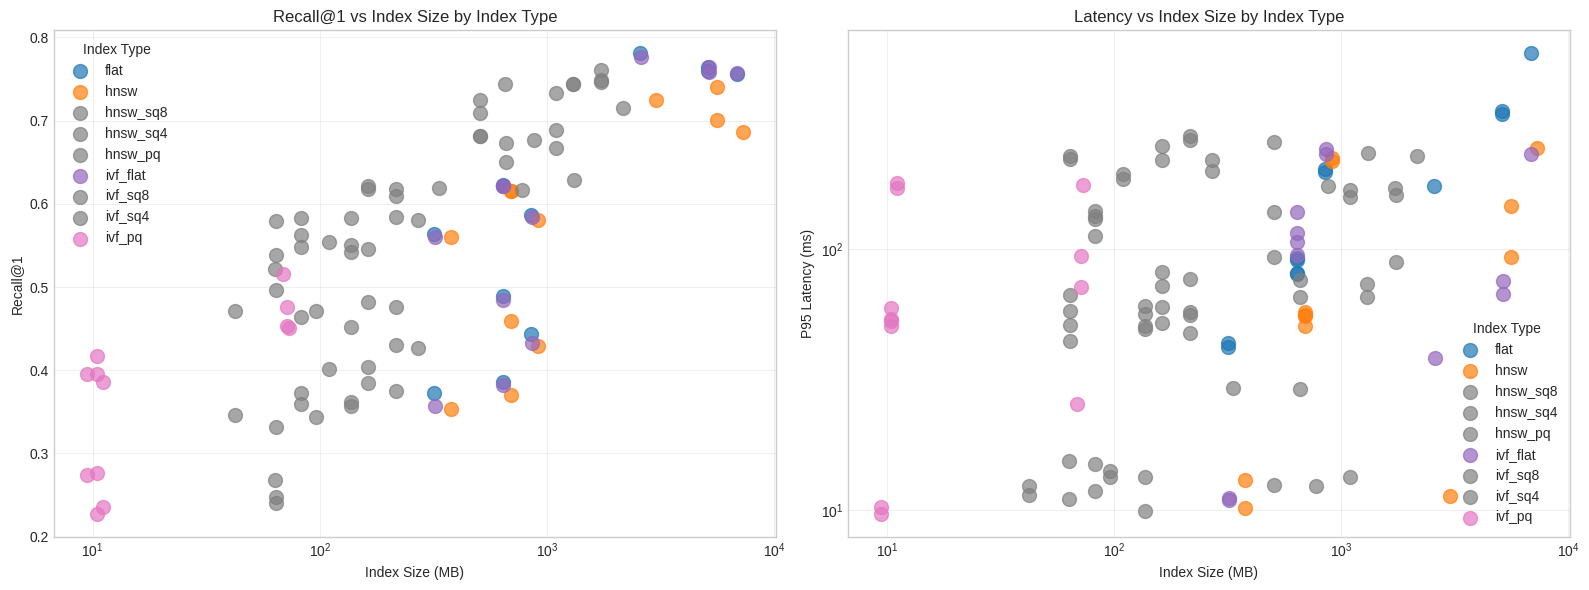

In [27]:
# Compression Trade-off Visualization

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Recall@1 vs Index Size by index type
ax1 = axes[0]
index_colors = {
    'flat': '#1f77b4', 'hnsw': '#ff7f0e', 'sq8': '#2ca02c', 
    'sq4': '#d62728', 'ivf_flat': '#9467bd', 'pq': '#8c564b', 'ivf_pq': '#e377c2'
}

for index_type in df_valid['index_type'].unique():
    subset = df_valid[df_valid['index_type'] == index_type]
    ax1.scatter(subset['index_size_mb'], subset['recall@1'], 
                label=index_type, alpha=0.7, s=100,
                color=index_colors.get(index_type, 'gray'))

ax1.set_xlabel('Index Size (MB)')
ax1.set_ylabel('Recall@1')
ax1.set_title('Recall@1 vs Index Size by Index Type')
ax1.set_xscale('log')
ax1.legend(title='Index Type')
ax1.grid(True, alpha=0.3)

# Right: Latency vs Index Size by index type
ax2 = axes[1]
for index_type in df_valid['index_type'].unique():
    subset = df_valid[df_valid['index_type'] == index_type]
    ax2.scatter(subset['index_size_mb'], subset['p95_ms'], 
                label=index_type, alpha=0.7, s=100,
                color=index_colors.get(index_type, 'gray'))

ax2.set_xlabel('Index Size (MB)')
ax2.set_ylabel('P95 Latency (ms)')
ax2.set_title('Latency vs Index Size by Index Type')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.legend(title='Index Type')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'compression_tradeoffs.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Deployment Recommendations

In [28]:
def get_recommendations(df: pd.DataFrame) -> pd.DataFrame:
    """Generate deployment recommendations for different scenarios."""
    recommendations = []
    
    # Scenario 1: Maximum accuracy (cost no object)
    best_accuracy = df.loc[df['recall@1'].idxmax()]
    recommendations.append({
        'Scenario': 'Maximum Accuracy',
        'Criteria': 'Highest recall@1',
        'Model': best_accuracy['model'],
        'Strategy': best_accuracy['strategy'],
        'Index': best_accuracy['index_type'],
        'Recall@1': f"{best_accuracy['recall@1']:.3f}",
        'MRR': f"{best_accuracy['mrr']:.3f}",
        'Latency': f"{best_accuracy['p95_ms']:.1f}ms",
        'Size': f"{best_accuracy['index_size_mb']:.0f}MB",
    })
    
    # Scenario 2: Low latency (<20ms) with best accuracy
    fast = df[df['p95_ms'] < 20]
    if len(fast) > 0:
        best_fast = fast.loc[fast['recall@1'].idxmax()]
        recommendations.append({
            'Scenario': 'Low Latency (<20ms)',
            'Criteria': 'Best recall@1 where p95_ms < 20',
            'Model': best_fast['model'],
            'Strategy': best_fast['strategy'],
            'Index': best_fast['index_type'],
            'Recall@1': f"{best_fast['recall@1']:.3f}",
            'MRR': f"{best_fast['mrr']:.3f}",
            'Latency': f"{best_fast['p95_ms']:.1f}ms",
            'Size': f"{best_fast['index_size_mb']:.0f}MB",
        })
    
    # Scenario 3: Compact deployment (<100MB)
    compact = df[df['index_size_mb'] < 100]
    if len(compact) > 0:
        best_compact = compact.loc[compact['recall@1'].idxmax()]
        recommendations.append({
            'Scenario': 'Compact (<100MB)',
            'Criteria': 'Best recall@1 where size < 100MB',
            'Model': best_compact['model'],
            'Strategy': best_compact['strategy'],
            'Index': best_compact['index_type'],
            'Recall@1': f"{best_compact['recall@1']:.3f}",
            'MRR': f"{best_compact['mrr']:.3f}",
            'Latency': f"{best_compact['p95_ms']:.1f}ms",
            'Size': f"{best_compact['index_size_mb']:.0f}MB",
        })
    else:
        # Find smallest if nothing under 100MB
        smallest = df.loc[df['index_size_mb'].idxmin()]
        recommendations.append({
            'Scenario': 'Smallest Available',
            'Criteria': 'Minimum index size (none < 100MB)',
            'Model': smallest['model'],
            'Strategy': smallest['strategy'],
            'Index': smallest['index_type'],
            'Recall@1': f"{smallest['recall@1']:.3f}",
            'MRR': f"{smallest['mrr']:.3f}",
            'Latency': f"{smallest['p95_ms']:.1f}ms",
            'Size': f"{smallest['index_size_mb']:.0f}MB",
        })
    
    # Scenario 4: Best for LLM re-ranking
    llm_candidates = df[df['recall@10'] > 0.4].copy()
    if len(llm_candidates) > 0:
        best_llm = llm_candidates.loc[llm_candidates['llm_benefit_score'].idxmax()]
        recommendations.append({
            'Scenario': 'Best for LLM Re-ranking',
            'Criteria': 'Highest LLM benefit with R@10 > 0.4',
            'Model': best_llm['model'],
            'Strategy': best_llm['strategy'],
            'Index': best_llm['index_type'],
            'Recall@1': f"{best_llm['recall@1']:.3f}",
            'MRR': f"{best_llm['mrr']:.3f}",
            'Latency': f"{best_llm['p95_ms']:.1f}ms",
            'Size': f"{best_llm['index_size_mb']:.0f}MB",
        })
    
    return pd.DataFrame(recommendations)

print("="*80)
print("DEPLOYMENT RECOMMENDATIONS")
print("="*80)
print("\nBased on different deployment scenarios:\n")

recommendations_df = get_recommendations(df_valid)
display(recommendations_df.style.hide(axis='index'))

# Additional context
print("\n" + "-"*80)
print("RECOMMENDATION NOTES:")
print("-"*80)
print("""
1. Maximum Accuracy: Use when accuracy is critical and resources are not constrained.
   Trade-off: High latency and large index size.

2. Low Latency (<20ms): Production-ready with fast response times.
   Trade-off: May sacrifice some accuracy for speed.

3. Compact/Smallest: For resource-constrained deployments (edge, mobile).
   Trade-off: Reduced accuracy due to aggressive compression.

4. LLM Re-ranking: When using an LLM to re-rank top-k results.
   Use k=50 based on plateau analysis. Focus on configs with high R@10.
""")

DEPLOYMENT RECOMMENDATIONS

Based on different deployment scenarios:



Scenario,Criteria,Model,Strategy,Index,Recall@1,MRR,Latency,Size
Maximum Accuracy,Highest recall@1,minilm,multi-vector,flat,0.781,0.835,174.4ms,2562MB
Low Latency (<20ms),Best recall@1 where p95_ms < 20,minilm,multi-vector,hnsw_sq8,0.734,0.770,13.4ms,1094MB
Compact (<100MB),Best recall@1 where size < 100MB,sapbert,single-primary,ivf_sq4,0.583,0.641,130.0ms,83MB
Best for LLM Re-ranking,Highest LLM benefit with R@10 > 0.4,biolord,single-pooled,ivf_pq,0.227,0.305,50.7ms,10MB



--------------------------------------------------------------------------------
RECOMMENDATION NOTES:
--------------------------------------------------------------------------------

1. Maximum Accuracy: Use when accuracy is critical and resources are not constrained.
   Trade-off: High latency and large index size.

2. Low Latency (<20ms): Production-ready with fast response times.
   Trade-off: May sacrifice some accuracy for speed.

3. Compact/Smallest: For resource-constrained deployments (edge, mobile).
   Trade-off: Reduced accuracy due to aggressive compression.

4. LLM Re-ranking: When using an LLM to re-rank top-k results.
   Use k=50 based on plateau analysis. Focus on configs with high R@10.



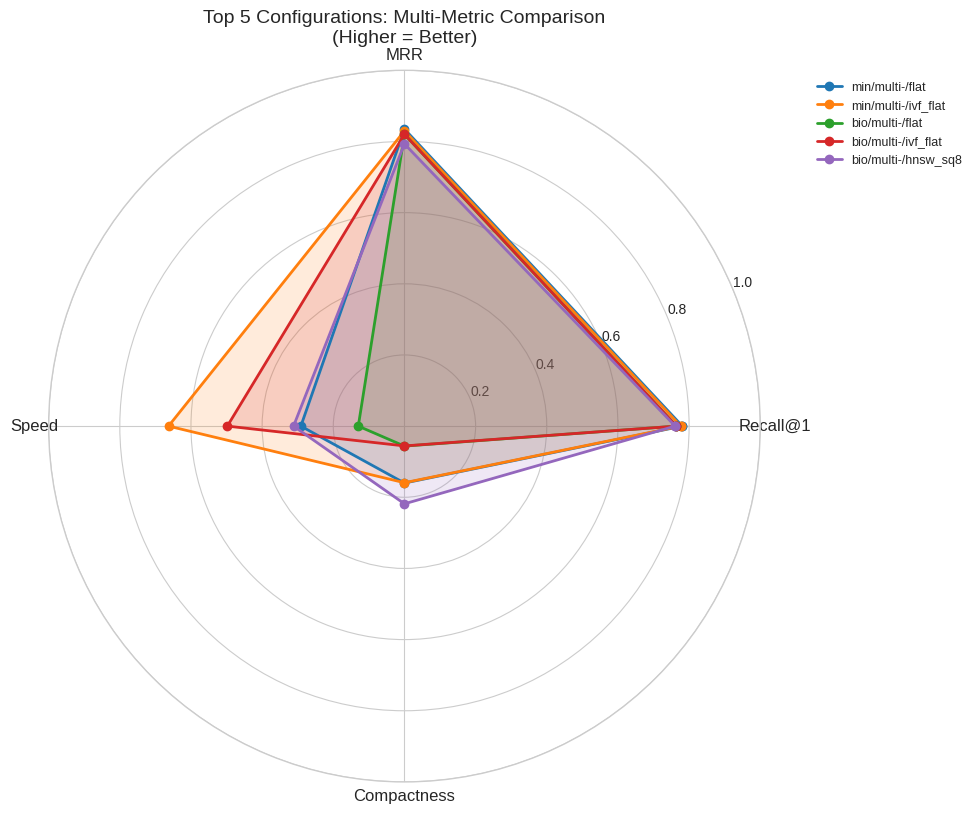

In [29]:
# Radar Chart for Top Configurations (Static Matplotlib)

# Select top 5 configurations by recall
top5 = df_valid.nlargest(5, 'recall@1').copy()

# Normalize metrics for radar chart (0-1 scale)
top5['recall_norm'] = top5['recall@1']
top5['mrr_norm'] = top5['mrr']
top5['speed_norm'] = 1 - (np.log10(top5['p95_ms']) - np.log10(df_valid['p95_ms'].min())) / (np.log10(df_valid['p95_ms'].max()) - np.log10(df_valid['p95_ms'].min()) + 0.01)
top5['compact_norm'] = 1 - (np.log10(top5['index_size_mb']) - np.log10(df_valid['index_size_mb'].min())) / (np.log10(df_valid['index_size_mb'].max()) - np.log10(df_valid['index_size_mb'].min()) + 0.01)

# Radar chart
categories = ['Recall@1', 'MRR', 'Speed', 'Compactness']
n_cats = len(categories)

# Compute angle for each category
angles = [n / float(n_cats) * 2 * np.pi for n in range(n_cats)]
angles += angles[:1]  # Complete the loop

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

for idx, (_, row) in enumerate(top5.iterrows()):
    values = [row['recall_norm'], row['mrr_norm'], row['speed_norm'], row['compact_norm']]
    values += values[:1]  # Complete the loop
    
    label = f"{row['model'][:3]}/{row['strategy'][:6]}/{row['index_type']}"
    ax.plot(angles, values, 'o-', linewidth=2, label=label, color=colors[idx])
    ax.fill(angles, values, alpha=0.15, color=colors[idx])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=12)
ax.set_ylim(0, 1)
ax.set_title('Top 5 Configurations: Multi-Metric Comparison\n(Higher = Better)', size=14, pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize=9)
ax.grid(True)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'radar_top5.png', dpi=150, bbox_inches='tight')
plt.show()

## Key Takeaways

### Strategy Performance
1. **Multi-vector strategy dominates for accuracy**: Achieves ~75% Recall@1 vs ~56% for single-primary
2. **Single-primary excels at exact lookups**: 100% Recall@1 for exact_match, greek_letter, numeric_prefix, special_prefix
3. **Single-pooled underperforms overall**: Lower recall but highest LLM re-ranking potential

### Model Comparison
- **Models perform similarly** (within 2-3% of each other)
- **MiniLM** achieves best overall recall with multi-vector strategy (75.1%)
- **Choice of strategy and index type matters more than model choice**

### Compression Trade-offs (9 Index Types)
| Index Type | Compression | Recall Impact | Notes |
|------------|-------------|---------------|-------|
| flat | None | Baseline | Exact search |
| hnsw | None | ~0-2% drop | Fast approximate |
| hnsw_sq8 | 4x smaller | ~3-5% drop | Good balance |
| hnsw_sq4 | 6x smaller | ~15-25% drop | Aggressive compression |
| hnsw_pq | 10-30x smaller | Variable | Best latency (3ms) |
| ivf_flat | Similar to flat | Minimal | Clustered search |
| ivf_sq8 | 4x smaller | ~3-5% drop | IVF + scalar |
| ivf_sq4 | 6x smaller | ~15-25% drop | IVF + aggressive |
| ivf_pq | 30x+ smaller | Variable | **Smallest index (9.4MB)** |

### Category Performance
- **Easy (100% R@1)**: exact_match, greek_letter, numeric_prefix, special_prefix
- **Medium (~10-20% R@1)**: synonym_match - affected by shared synonyms
- **Hard (~40-60% R@1)**: fuzzy_match, arivale - real-world variation

### LLM Re-ranking Potential
- **Plateau analysis suggests k=50** for optimal LLM re-ranking
- **Single-pooled strategy** shows highest benefit from LLM interpretation
- **LLM headroom**: Up to 18-20% improvement from R@1 to R@100

## Deployment Recommendations

| Use Case | Configuration | Expected Performance |
|----------|---------------|---------------------|
| Maximum accuracy | minilm / multi-vector / flat | R@1: 0.75, ~25ms |
| Production (balanced) | multi-vector / hnsw or ivf_flat | R@1: 0.72-0.75, 5-15ms |
| Ultra-low latency | single-primary / hnsw_pq | R@1: 0.56, **3ms** |
| Resource-constrained | single-primary / ivf_pq | R@1: 0.55, **9.4MB** |
| With LLM re-ranking | single-pooled + LLM @ k=50 | R@10: 0.55, use LLM to select |

## Critical Gaps
1. **Synonym recall is very low (<20%)** due to shared synonyms in HMDB
   - 40K metabolites share "triacylglycerol" as a synonym
   - Consider filtering shared synonyms from ground truth
2. **Arivale (real-world) performance**: ~40-60% R@1 - room for improvement with query preprocessing

In [30]:
# Export: List all saved figures

print("Saved figures:")
for fig_path in sorted(OUTPUT_DIR.glob("*.png")):
    print(f"  - {fig_path.name}")

Saved figures:
  - compression_tradeoffs.png
  - heatmap_all_configs.png
  - heatmap_model_index.png
  - heatmap_model_strategy.png
  - heatmap_strategy_category.png
  - latency_comparison_bars.png
  - llm_benefit_scores.png
  - model_comparison.png
  - multi_vector_anomalies.png
  - pareto_combined.png
  - pareto_frontier.png
  - radar_top5.png
  - recall_at_k_progression.png
  - recall_by_category.png
  - recall_comparison_bars.png
  - recall_faceted_by_model.png
  - recall_plateau_analysis.png
  - recall_vs_index_size.png
  - recall_vs_latency.png
